<a href="https://colab.research.google.com/github/Rivuozil/Skin-Cancer-Classification-for-Imbalanced-Datasets/blob/notebooks/notebooks/ASAN_EMB_MLP_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Global params


class Globals:
  # @markdown GCP project with GCS bucket of interest:
  gcp_project = 'mineral-liberty-429713-r0'  # @param

  # GCS bucket with data to read:
  gcs_bucket_name = 'asan_preprocessed_embeddings'  # @param

  # @markdown PAD Dataset files:
  # Metadata CSV from PAD dataset to read
  gcs_metadata_csv = '/content/metadata_asan.csv'  # @param

  # Images directory:
  gcs_images_dir = 'images' #@param

  # Column name to use for the small model
  label_column = 'labels'  # @param

  # Column to join the CSV to the images by path
  img_join_column = 'image_paths' # @param

  # @markdown If precomputed embeddings should be used:
  # When true, use precomputed embeddings instead of generating
  # from scratch.
  gcs_use_precomputed_embeddings = False  # @param {type: "boolean"}

  # Path to precomputed embeddings
  gcs_precomputed_embeddings = 'pad_dataset/precomputed/embeddings.npz'  # @param

  # Access Token for `gcs_bucket_name`.
  # Note: You can also manually create and set this
  #   by using `gcloud auth print-access-token` in your local
  #   environment.
  gcs_creds = None

  # @markdown ---
  # @markdown Vertex AI end-point configuration:
  vertex_endpoint_project_id = '132886652110'  # @param
  vertex_endpoint_id = '180'  # @param
  vertex_endpoint_location = 'us-central1'  # @param

  random_state = 3141
  embeddings_size = 6144
  # @markdown ---
  # @markdown Training Parameters--Adjust this to reduce or increase the training size as a % of total training:
  train_split_size = 0.8 # @param
  # Note: this variable sets the training split. We set it by default to 0.15 to show how effective the model is on a small amount of data. You can increase it to see how more data improves the accuracy.

  ###### Formed during execution:

  # Client for querying GCS
  gcs_storage_client = None

  # Bucket object for loading files
  gcs_bucket = None

  # pd.DataFrame for the loaded metadata_csv
  metadata_df = None


  # Dict from image path -> embedding
  embeddings = dict()

  # pd.DataFrames for training/validation data splits
  df_train = None
  df_validate = None

  # ML model
  model1 = None
  model2 = None

In [ ]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

In [ ]:
import datetime
import google.auth
import google.auth.transport.requests

Globals.gcs_creds, project = google.auth.default()


def initial_token_refresh():
  # Refresh credentials so an access token is available.
  auth_req = google.auth.transport.requests.Request()
  Globals.gcs_creds.refresh(auth_req)
  assert (
      Globals.gcs_creds.valid
  ), f'Unexpected error: GCS Credentials are invalid'
  time_until_expiry = (
      Globals.gcs_creds.expiry - datetime.datetime.utcnow()
  ).total_seconds() // 60
  print(
      'Token will expire at'
      f' {Globals.gcs_creds.expiry.strftime("%Y-%m-%d %H:%M:%S")} UTC'
      f' ({time_until_expiry} minutes)'
  )


initial_token_refresh()
print(Globals.gcs_creds)

Token will expire at 2024-08-18 07:11:31 UTC (59.0 minutes)


In [ ]:
# @title Imports

import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time
from typing import List, Text
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tabulate
import tensorflow as tf
import torch
import torch.nn.init as init


from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, precision_score, accuracy_score
from torch.utils.data import DataLoader, WeightedRandomSampler, BatchSampler, Sampler
from sklearn.model_selection import StratifiedKFold

In [ ]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed) #LYZ: Set Python's hash seed to ensure consistent hashing operations.
    np.random.seed(seed)#Set NumPy’s random seed
    torch.manual_seed(seed)#Set NumPy’s random seed
    torch.cuda.manual_seed(seed)#Set PyTorch's GPU random seed.
    torch.backends.cudnn.deterministic = True# Set to use deterministic algorithms when using CuDNN (GPU-accelerated deep learning library) to ensure repeatability of results.
    torch.backends.cudnn.benchmark = True #Set to enable performance optimization of CuDNN to run faster.

    #LYZ: The call of this function can ensure that operations involving randomness (such as parameter initialization, data enhancement, etc.) are repeatable in different runs of the code.

seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CPU" device.


In [ ]:
classes_to_int_asan = {'ak':0, 'bcc':1, 'dermatofibroma':2, 'hemangioma':3, 'intraepithelial carcinoma':4, 'lentigo':5, 'melanoma':6, 'nevus':7, 'pyogenic granuloma':8, 'scc':9, 'sebk':10,'wart':11}
int_to_classes_asan = {0:'ak', 1:'bcc', 2:'dermatofibroma', 3:'hemangioma', 4:'intraepithelial carcinoma', 5:'lentigo', 6:'melanoma', 7:'nevus', 8:'pyogenic granuloma', 9:'scc', 10:'sebk', 11:'wart'}

num_classes=len(int_to_classes_asan.keys())
embedding_dim=6144
batch_size=32
learning_rate=0.001
epochs=40

print(num_classes)

12


In [ ]:
from google.cloud import storage


def list_blobs(storage_client, bucket_name):
  """Helper to list blobs in a bucket (useful for debugging)."""
  blobs = storage_client.list_blobs(bucket_name)
  for blob in blobs:
    print(blob)


def load_dataset(bucket, csv_path, images_dir):
  """Loads the given CSV into a pd.DataFrame."""
  #images_dir=os.path.join(Globals.gcs_bucket_name,images_dir)
  df = pd.read_csv(Globals.gcs_metadata_csv)
  df['img_path'] = df[Globals.img_join_column].apply(lambda x: os.path.join(images_dir, x))
  #df['img_path'] = df['img_path'].replace('\\','/')
  return df


Globals.gcs_storage_client = storage.Client(Globals.gcp_project)
#list_blobs(Globals.gcs_storage_client, Globals.gcs_bucket_name)
Globals.gcs_bucket = Globals.gcs_storage_client.bucket(Globals.gcs_bucket_name)
print(f'Bucket: {Globals.gcs_bucket.name}')
Globals.metadata_df = load_dataset(
    Globals.gcs_bucket, Globals.gcs_metadata_csv, Globals.gcs_images_dir
)
Globals.all_col_vals = sorted(set(Globals.metadata_df[Globals.label_column]))

Bucket: asan_preprocessed_embeddings


In [ ]:
Globals.metadata_df

,Unnamed: 0,image_paths,labels,img_path
0,0,test/ak/prefix00.png,0,images/test/ak/prefix00.png
1,1,test/ak/prefix01.png,0,images/test/ak/prefix01.png
2,2,test/ak/prefix02.png,0,images/test/ak/prefix02.png
3,3,test/ak/prefix03.png,0,images/test/ak/prefix03.png
4,4,test/ak/prefix10.png,0,images/test/ak/prefix10.png
...,...,...,...,...
12205,12205,val/wart/prefix86.png,11,images/val/wart/prefix86.png
12206,12206,val/wart/prefix87.png,11,images/val/wart/prefix87.png
12207,12207,val/wart/prefix88.png,11,images/val/wart/prefix88.png
12208,12208,val/wart/prefix89.png,11,images/val/wart/prefix89.png


In [ ]:
file_path='/content/drive/MyDrive/Swarnava/asan_embeddings.json'

with open(file_path, 'r') as file:
    data=json.load(file)

embeddings_map=data.copy()


In [ ]:
# Check that we have an embedding for every image
if len(embeddings_map.keys()) < len(Globals.metadata_df):
  raise ValueError(
      f'Expected {len(Globals.metadata_df)} embeddings to be present. '
      f'Got {len(embeddings_map.keys())}.\n'
      'Maybe the "Generate embeddings" cell should be run again? This can '
      'happen if there are intermittent API errors.'
  )

In [ ]:
class_data_melanoma=Globals.metadata_df[Globals.metadata_df["labels"]==0]
class_data_melanoma

,Unnamed: 0,image_paths,labels,img_path
0,0,test/ak/prefix00.png,0,images/test/ak/prefix00.png
1,1,test/ak/prefix01.png,0,images/test/ak/prefix01.png
2,2,test/ak/prefix02.png,0,images/test/ak/prefix02.png
3,3,test/ak/prefix03.png,0,images/test/ak/prefix03.png
4,4,test/ak/prefix10.png,0,images/test/ak/prefix10.png
...,...,...,...,...
11174,11174,val/ak/prefix31.png,0,images/val/ak/prefix31.png
11175,11175,val/ak/prefix32.png,0,images/val/ak/prefix32.png
11176,11176,val/ak/prefix33.png,0,images/val/ak/prefix33.png
11177,11177,val/ak/prefix34.png,0,images/val/ak/prefix34.png


In [ ]:
seed=42

from sklearn.model_selection import train_test_split
data=Globals.metadata_df
test_data=pd.DataFrame(columns=Globals.metadata_df.columns)


for class_idx in int_to_classes_asan.keys():
    print(class_idx)
    class_data=Globals.metadata_df[Globals.metadata_df["labels"]==class_idx]
    train_valid_split, test_split=train_test_split(class_data, test_size=0.1, stratify=class_data['labels'], random_state=seed)
    test_data=pd.concat([test_data, test_split])

data=data[~data["image_paths"].isin(test_data["image_paths"])]

train_split,validation_split=train_test_split(data, test_size=0.1, stratify=data["labels"], random_state=seed)
train_split, calib_split=train_test_split(train_split, test_size=0.1, stratify=train_split["labels"], random_state=seed)

train_split.reset_index(drop=True, inplace=True)
validation_split.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
calib_split.reset_index(drop=True, inplace=True)

print(len(train_split))
print(len(validation_split))
print(len(test_data))
print(len(calib_split))

0
1
2
3
4
5
6
7
8
9
10
11
8895
1099
1227
989


In [ ]:
from sklearn.model_selection import train_test_split
seed=42

train_split=Globals.metadata_df[Globals.metadata_df['img_path'].str.contains('train')]
validation_split=Globals.metadata_df[Globals.metadata_df['img_path'].str.contains('val')]
test_data=Globals.metadata_df[Globals.metadata_df['img_path'].str.contains('test')]

train_split, calib_split=train_test_split(train_split, test_size=0.1, stratify=train_split["labels"], random_state=seed)

train_split.reset_index(drop=True, inplace=True)
validation_split.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
calib_split.reset_index(drop=True, inplace=True)

train_split=train_split[:len(train_split)-1]
print(len(train_split))
print(len(validation_split))
print(len(test_data))
print(len(calib_split))


8864
1086
1274
985


In [ ]:
test_data

,Unnamed: 0,image_paths,labels,img_path
0,0,test/ak/prefix00.png,0,images/test/ak/prefix00.png
1,1,test/ak/prefix01.png,0,images/test/ak/prefix01.png
2,2,test/ak/prefix02.png,0,images/test/ak/prefix02.png
3,3,test/ak/prefix03.png,0,images/test/ak/prefix03.png
4,4,test/ak/prefix10.png,0,images/test/ak/prefix10.png
...,...,...,...,...
1269,1269,test/wart/prefix95.png,11,images/test/wart/prefix95.png
1270,1270,test/wart/prefix96.png,11,images/test/wart/prefix96.png
1271,1271,test/wart/prefix97.png,11,images/test/wart/prefix97.png
1272,1272,test/wart/prefix98.png,11,images/test/wart/prefix98.png


In [ ]:
train_split.loc[train_split['img_path']=='images/ISIC_2019_Training_Input_4/ISIC_0063663.jpg']

,Unnamed: 0,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,labels,img_path
1640,19272,ISIC_0063663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,images/ISIC_2019_Training_Input_4/ISIC_0063663...


In [ ]:
class embDataset(torch.utils.data.Dataset):
    def __init__(self, data, embeddings_map):
        self.data = data
        self.embeddings_map = embeddings_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, id):
        image_path = self.data["img_path"][id]
        parent_folder = image_path.split('/')[-2]


        # Retrieve the embedding for the image path
        emb = self.embeddings_map.get(image_path)
        if emb is None:
            raise ValueError(f"Embedding not found for {image_path}")

        emb = torch.tensor(emb, dtype=torch.float32)

        # Retrieve the label for the image path
        label = torch.as_tensor(
            self.data.loc[self.data["img_path"] == image_path, "labels"].item(),
            dtype=torch.int64
        )

        return emb, label

    def collate_fn(self, batch):
        # Filter out None values (if any)
        batch = [item for item in batch if item is not None]
        emb, labels = list(zip(*batch))
        emb = torch.stack(emb, dim=0).to(device)
        labels = torch.tensor(labels).to(device)
        return emb, labels

class smoteDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings= embeddings
        self.labels=labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, id):
        emb=self.embeddings[id]

        if emb is None:
            raise ValueError(f"Embedding not found for {id}")

        emb = torch.tensor(emb, dtype=torch.float32)

        # Retrieve the label for the image path
        label = torch.as_tensor(
            self.labels[id],
            dtype=torch.int64
        )

        return emb, label

    def collate_fn(self, batch):
        # Filter out None values (if any)
        batch = [item for item in batch if item is not None]
        emb, labels = list(zip(*batch))
        emb = torch.stack(emb, dim=0).to(device)
        labels = torch.tensor(labels).to(device)
        return emb, labels

class ClassDataset(torch.utils.data.Dataset):
    def __init__(self, data=None, labels=None):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        # load image and labels
        if self.data is not None:
            emb = torch.as_tensor(self.data[index], dtype=torch.float64)


        label = torch.as_tensor(self.labels[index], dtype=torch.int64)

        return emb,label

    def __len__(self):
        return len(self.data)

    def collate_fn(self, batch):
        # Filter out None values (if any)
        batch = [item for item in batch if item is not None]
        emb, labels = list(zip(*batch))
        emb = torch.stack(emb, dim=0).to(device)
        labels = torch.tensor(labels).to(device)
        return emb, labels
# Dataset and DataLoader setup
ISICEmbTrainSet = embDataset(train_split, embeddings_map)
ISICEmbValSet = embDataset(validation_split, embeddings_map)
ISICEmbTestSet = embDataset(test_data, embeddings_map)
ISICEmbCalibSet = embDataset(calib_split, embeddings_map)
#ASANEmbAugSet = smoteDataset(asan_resampled_embs, asan_resampled_labels)

ISICEmbTrainLoader = torch.utils.data.DataLoader(
    ISICEmbTrainSet, batch_size=batch_size, shuffle=True, collate_fn=ISICEmbTrainSet.collate_fn
)
ISICEmbValLoader = torch.utils.data.DataLoader(
    ISICEmbValSet, batch_size=batch_size, shuffle=False, collate_fn=ISICEmbValSet.collate_fn
)
ISICEmbCalibLoader = torch.utils.data.DataLoader(
    ISICEmbCalibSet, batch_size=1, shuffle=False, collate_fn=ISICEmbCalibSet.collate_fn
)
ISICEmbTestLoader = torch.utils.data.DataLoader(
    ISICEmbTestSet, batch_size=batch_size, shuffle=False, collate_fn=ISICEmbTestSet.collate_fn
)
ISICEmbTestLoader2 = torch.utils.data.DataLoader(
    ISICEmbTestSet, batch_size=1, shuffle=False, collate_fn=ISICEmbTestSet.collate_fn
)
#ASANEmbAugLoader = torch.utils.data.DataLoader(
#    ASANEmbAugSet, batch_size=batch_size, shuffle=True, collate_fn=ASANEmbAugSet.collate_fn
#)
# Test the DataLoader




In [ ]:
print(ISICEmbTrainSet.data)

      Unnamed: 0                                     image_paths  labels  \
0           2121                        train/bcc/prefix1721.png       1   
1           9840                       train/wart/prefix1285.png      11   
2           6088                      train/nevus/prefix1349.png       7   
3           3921                  train/hemangioma/prefix324.png       3   
4           4351  train/intraepithelial carcinoma/prefix1437.png       4   
...          ...                                             ...     ...   
8859        4390  train/intraepithelial carcinoma/prefix1536.png       4   
8860        7449                       train/nevus/prefix890.png       7   
8861        2653             train/dermatofibroma/prefix1049.png       2   
8862        2995             train/dermatofibroma/prefix1729.png       2   
8863        1421                         train/ak/prefix1515.png       0   

                                               img_path  
0                       image

In [ ]:
class_counts=train_split['labels'].value_counts()

print(class_counts)

labels
7     1653
11    1392
9      861
2      810
1      756
10     697
4      633
3      584
0      446
6      424
5      348
8      260
Name: count, dtype: int64


In [ ]:
class_counts_val=validation_split['labels'].value_counts()

print(class_counts_val)

labels
7     204
11    171
9     106
2      95
1      93
10     86
4      78
3      72
0      55
6      52
5      42
8      32
Name: count, dtype: int64


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
variance=0.90
pca=PCA(n_components=variance)
scaler=MinMaxScaler()
asan_train_embeddings=np.zeros((len(train_split),6144))
asan_train_labels=np.zeros(len(train_split)).astype(int)
index=0


for i in range(len(train_split)):
    asan_train_embeddings[index]=embeddings_map[train_split['img_path'][i]]
    asan_train_labels[index]=int(train_split['labels'][i])
    index+=1
#asan_reduced_embeddings=pca.fit_transform(asan_embeddings)
#asan_normalized_embeddings=scaler.fit_transform(asan_train_embeddings)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

asan_valid_embs=np.zeros((len(validation_split),6144))
asan_valid_labels=np.zeros(len(validation_split)).astype(int)
asan_test_embs=np.zeros((len(test_data),6144))
asan_test_labels=np.zeros(len(test_data)).astype(int)
asan_calib_embs=np.zeros((len(calib_split),6144))
asan_calib_labels=np.zeros(len(calib_split)).astype(int)
index=0

variance_test=207
pca=PCA(n_components=variance_test)
scaler=MinMaxScaler()

for i in range(len(validation_split)):
    asan_valid_embs[index]=embeddings_map[validation_split['img_path'][i]]
    asan_valid_labels[index]=int(validation_split['labels'][i])
    index+=1
index=0
for i in range(len(test_data)):
    asan_test_embs[index]=embeddings_map[test_data['img_path'][i]]
    asan_test_labels[index]=int(test_data['labels'][i])
    index+=1
index=0
for i in range(len(calib_split)):
    asan_calib_embs[index]=embeddings_map[calib_split['img_path'][i]]
    asan_calib_labels[index]=int(calib_split['labels'][i])
    index+=1
'''
asan_reduced_valid_embs=pca.fit_transform(asan_valid_embs)
asan_reduced_test_embs=pca.fit_transform(asan_test_embs)
asan_reduced_calib_embs=pca.fit_transform(asan_calib_embs)

asan_normalized_valid_embs=scaler.fit_transform(asan_valid_embs)
asan_normalized_calib_embs=scaler.fit_transform(asan_calib_embs)
asan_normalized_test_embs=scaler.fit_transform(asan_test_embs)

asan_reduced_valid_embs=np.array(asan_reduced_valid_embs.transform(asan_valid_embs))
asan_reduced_test_embs=np.array(asan_reduced_test_embs.transform(asan_test_embs))
asan_reduced_calib_embs=np.array(asan_reduced_calib_embs.transform(asan_calib_embs))'''

'\nasan_reduced_valid_embs=pca.fit_transform(asan_valid_embs)\nasan_reduced_test_embs=pca.fit_transform(asan_test_embs)\nasan_reduced_calib_embs=pca.fit_transform(asan_calib_embs)\n\nasan_normalized_valid_embs=scaler.fit_transform(asan_valid_embs)\nasan_normalized_calib_embs=scaler.fit_transform(asan_calib_embs)\nasan_normalized_test_embs=scaler.fit_transform(asan_test_embs)\n\nasan_reduced_valid_embs=np.array(asan_reduced_valid_embs.transform(asan_valid_embs))\nasan_reduced_test_embs=np.array(asan_reduced_test_embs.transform(asan_test_embs))\nasan_reduced_calib_embs=np.array(asan_reduced_calib_embs.transform(asan_calib_embs))'

In [ ]:
asan_embeddings=[]
asan_labels=[]

for i in range(len(asan_train_embeddings)):
    asan_embeddings.append(asan_train_embeddings[i])
    asan_labels.append(asan_train_labels[i])
for i in range(len(asan_valid_embs)):
    asan_embeddings.append(asan_valid_embs[i])
    asan_labels.append(asan_valid_labels[i])
for i in range(len(asan_test_embs)):
    asan_embeddings.append(asan_test_embs[i])
    asan_labels.append(asan_test_labels[i])
print(asan_train_embeddings.shape)
print(asan_train_labels.shape)
print(asan_valid_embs.shape)
print(asan_valid_labels.shape)
print(asan_test_embs.shape)
print(asan_test_labels.shape)
#asan_embeddings=np.append(asan_embeddings, asan_train_embeddings)
#asan_embeddings=np.append(asan_embeddings, asan_valid_embs)
#asan_embeddings=np.append(asan_embeddings, asan_test_embs)

#asan_labels=np.append(asan_labels, asan_train_labels)
#asan_labels=np.append(asan_labels, asan_valid_labels)
#asan_labels=np.append(asan_labels, asan_test_labels)
asan_embeddings=np.array(asan_embeddings)
asan_labels=np.array(asan_labels)
print(asan_embeddings.shape)
print(asan_labels.shape)

(8864, 6144)
(8864,)
(1086, 6144)
(1086,)
(1274, 6144)
(1274,)
(11224, 6144)
(11224,)


In [ ]:
print(asan_resampled_embs.dtype)

float64


In [ ]:
#asan_reduced_embeddings = np.array(asan_reduced_embeddings.transform(asan_embeddings))
print(asan_reduced_embs.shape)
print(asan_embeddings.shape)
print(asan_reduced_test_embs.shape)
print(asan_reduced_valid_embs.shape)

AttributeError: 'PCA' object has no attribute 'shape'

In [ ]:
from imblearn.over_sampling import SMOTE

smote1=SMOTE(sampling_strategy='auto', random_state=42)
asan_resampled_embs, asan_resampled_labels=smote1.fit_resample(asan_embeddings, asan_labels)
print(asan_resampled_embs.shape)
print(asan_resampled_labels.shape)

(15720, 6144)
(15720,)


In [ ]:
from sklearn.utils import resample

target_count_asan=350
train_split_undersampled=pd.DataFrame()
for class_idx, counts in class_counts.items():
    class_data = train_split[train_split["labels"] == class_idx]
    if(counts>=target_count_asan):
        class_data=resample(class_data, replace=False, n_samples=target_count_asan, random_state=42)
        train_split_undersampled=pd.concat([train_split_undersampled, class_data])

train_split_undersampled=pd.concat([train_split_undersampled, train_split[train_split["labels"]==8]])
train_split_undersampled.reset_index(drop=True, inplace=True)



In [ ]:
label_counts={i:0 for i in int_to_classes_asan.keys()}

for label in asan_resampled_labels:
    label_counts[label]+=1

print(label_counts)

{0: 1310, 1: 1310, 2: 1310, 3: 1310, 4: 1310, 5: 1310, 6: 1310, 7: 1310, 8: 1310, 9: 1310, 10: 1310, 11: 1310}


In [ ]:
class WeightSampler(Sampler):

    def __init__(self, data, weights):
        self.dataset=data
        self.weights=weights
        self.n=len(data)
        self.weights_mean=np.mean(self.weights)
        self.weights_var=np.var(self.weights)
        self.weights_std=np.std(self.weights)
        self.min_weight=0.2


    def __iter__(self):
        class_0_idxs=np.where(self.dataset.data['labels']==0)[0]
        class_1_idxs=np.where(self.dataset.data['labels']==1)[0]
        class_2_idxs=np.where(self.dataset.data['labels']==2)[0]
        class_3_idxs=np.where(self.dataset.data['labels']==3)[0]
        class_4_idxs=np.where(self.dataset.data['labels']==4)[0]
        class_5_idxs=np.where(self.dataset.data['labels']==5)[0]
        class_6_idxs=np.where(self.dataset.data['labels']==6)[0]
        class_7_idxs=np.where(self.dataset.data['labels']==7)[0]
        class_8_idxs=np.where(self.dataset.data['labels']==8)[0]
        class_9_idxs=np.where(self.dataset.data['labels']==9)[0]
        class_10_idxs=np.where(self.dataset.data['labels']==10)[0]
        class_11_idxs=np.where(self.dataset.data['labels']==11)[0]


        threshold = np.percentile(self.weights, 80)

        class_0=np.random.choice(class_0_idxs, size=int(self.n*self.weights[0]), replace=True) if self.weights[0]>threshold else class_0_idxs[:int(2*len(class_0_idxs)/3)]
        class_1=np.random.choice(class_1_idxs, size=int(self.n*self.weights[1]), replace=True) if self.weights[1]>threshold else class_1_idxs[:int(2*len(class_1_idxs)/3)]
        class_2=np.random.choice(class_2_idxs, size=int(self.n*self.weights[2]), replace=True) if self.weights[2]>threshold else class_2_idxs[:int(2*len(class_2_idxs)/3)]
        class_3=np.random.choice(class_3_idxs, size=int(self.n*self.weights[3]), replace=True) if self.weights[3]>threshold else class_3_idxs[:int(2*len(class_3_idxs)/3)]
        class_4=np.random.choice(class_4_idxs, size=int(self.n*self.weights[4]), replace=True) if self.weights[4]>threshold else class_4_idxs[:int(2*len(class_4_idxs)/3)]
        class_5=np.random.choice(class_5_idxs, size=int(self.n*self.weights[5]), replace=True) if self.weights[5]>threshold else class_5_idxs[:int(2*len(class_5_idxs)/3)]
        class_6=np.random.choice(class_6_idxs, size=int(self.n*self.weights[6]), replace=True) if self.weights[6]>threshold else class_6_idxs[:int(2*len(class_6_idxs)/3)]
        class_7=np.random.choice(class_7_idxs, size=int(self.n*self.weights[7]), replace=True) if self.weights[7]>threshold else class_7_idxs[:int(2*len(class_7_idxs)/3)]
        class_8=np.random.choice(class_8_idxs, size=int(self.n*self.weights[8]), replace=True) if self.weights[8]>threshold else class_8_idxs[:int(2*len(class_8_idxs)/3)]
        class_9=np.random.choice(class_9_idxs, size=int(self.n*self.weights[9]), replace=True) if self.weights[9]>threshold else class_9_idxs[:int(2*len(class_9_idxs)/3)]
        class_10=np.random.choice(class_10_idxs, size=int(self.n*self.weights[10]), replace=True) if self.weights[10]>threshold else class_10_idxs[:int(2*len(class_10_idxs)/3)]
        class_11=np.random.choice(class_11_idxs, size=int(self.n*self.weights[11]), replace=True) if self.weights[11]>threshold else class_11_idxs[:int(2*len(class_11_idxs)/3)]



        idxs=np.hstack([class_0, class_1, class_2, class_3, class_4, class_5, class_6, class_7, class_8, class_9, class_10, class_11])
        np.random.shuffle(idxs)
        idxs=idxs[:self.n]
        return iter(idxs)

    def __len__(self):
        return self.n

    def __datatype__(self):
        return(type.self.dataset.data['labels']==0)



In [ ]:
class_sampler.__datatype__()

AttributeError: 'WeightSampler' object has no attribute '__datatype__'

In [ ]:
class customSampler(Sampler):
 def __init__(self, data=None, labels=None, weights=None, n=None):
        self.data=data
        self.labels=labels
        self.weights=weights
        self.n=n

 def __iter__(self):
        class_0_idxs=np.where(self.labels==0)[0]
        class_1_idxs=np.where(self.labels==1)[0]
        class_2_idxs=np.where(self.labels==2)[0]
        class_3_idxs=np.where(self.labels==3)[0]
        class_4_idxs=np.where(self.labels==4)[0]
        class_5_idxs=np.where(self.labels==5)[0]
        class_6_idxs=np.where(self.labels==6)[0]
        class_7_idxs=np.where(self.labels==7)[0]
        class_8_idxs=np.where(self.labels==8)[0]
        class_9_idxs=np.where(self.labels==9)[0]
        class_10_idxs=np.where(self.labels==10)[0]
        class_11_idxs=np.where(self.labels==11)[0]

        threshold = 0.1

        class_0=np.random.choice(class_0_idxs, size=int(len(self.data)*self.weights[0]), replace=True) if self.weights[0]>threshold else class_0_idxs[:int(len(class_0_idxs)/2)]
        class_1=np.random.choice(class_1_idxs, size=int(len(self.data)*self.weights[1]), replace=True) if self.weights[1]>threshold else class_1_idxs[:int(len(class_1_idxs)/2)]
        class_2=np.random.choice(class_2_idxs, size=int(len(self.data)*self.weights[2]), replace=True) if self.weights[2]>threshold else class_2_idxs[:int(len(class_2_idxs)/2)]
        class_3=np.random.choice(class_3_idxs, size=int(len(self.data)*self.weights[3]), replace=True) if self.weights[3]>threshold else class_3_idxs[:int(len(class_3_idxs)/2)]
        class_4=np.random.choice(class_4_idxs, size=int(len(self.data)*self.weights[4]), replace=True) if self.weights[4]>threshold else class_4_idxs[:int(len(class_4_idxs)/2)]
        class_5=np.random.choice(class_5_idxs, size=int(len(self.data)*self.weights[5]), replace=True) if self.weights[5]>threshold else class_5_idxs[:int(len(class_5_idxs)/2)]
        class_6=np.random.choice(class_6_idxs, size=int(len(self.data)*self.weights[6]), replace=True) if self.weights[6]>threshold else class_6_idxs[:int(len(class_6_idxs)/2)]
        class_7=np.random.choice(class_7_idxs, size=int(len(self.data)*self.weights[7]), replace=True) if self.weights[7]>threshold else class_7_idxs[:int(len(class_7_idxs)/2)]
        class_8=np.random.choice(class_8_idxs, size=int(len(self.data)*self.weights[8]), replace=True) if self.weights[8]>threshold else class_8_idxs[:int(len(class_8_idxs)/2)]
        class_9=np.random.choice(class_9_idxs, size=int(len(self.data)*self.weights[9]), replace=True) if self.weights[9]>threshold else class_9_idxs[:int(len(class_9_idxs)/2)]
        class_10=np.random.choice(class_10_idxs, size=int(len(self.data)*self.weights[10]), replace=True) if self.weights[10]>threshold else class_10_idxs[:int(len(class_10_idxs)/2)]
        class_11=np.random.choice(class_11_idxs, size=int(len(self.data)*self.weights[11]), replace=True) if self.weights[11]>threshold else class_11_idxs[:int(len(class_11_idxs)/2)]

        idxs=np.hstack([class_0, class_1, class_2, class_3, class_4, class_5, class_6, class_7, class_8, class_9, class_10, class_11])
        np.random.shuffle(idxs)
        idxs=idxs[:self.n]
        return iter(idxs)

 def __len__(self):
        return self.n

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

brf=BalancedRandomForestClassifier(n_estimators=1000, criterion='entropy', max_features='sqrt', max_samples=0.8, bootstrap=True,
                                   min_samples_leaf=1, min_samples_split=3, class_weight=class_weights_dict, random_state=42, n_jobs=2,
                                   replacement=True, sampling_strategy='auto', max_depth=None)

brf.fit(asan_train_embeddings, asan_train_labels)
kfold=KFold(n_splits=10, shuffle=True, random_state=57)
accs=[]
scores=cross_val_score(brf, asan_test_embs, asan_test_labels, cv=kfold)

print("Accuracy scores:", scores)
print("Average accuracy:", np.mean(scores))
print("Standard deviation:", np.std(scores))

Accuracy scores: [0.6796875  0.7578125  0.78125    0.734375   0.72440945 0.67716535
 0.69291339 0.77165354 0.70866142 0.73228346]
Average accuracy: 0.7260211614173228
Standard deviation: 0.03490846940257617


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

param_grid = {
    'n_estimators': [20, 50, 100, 500, 1000],
    'criterion': ["gini", "entropy"],
    'min_samples_split': [2,3,4,5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap' : [True],
    'max_samples': [0.5, 0.8]
}

brf=BalancedRandomForestClassifier()
grid_search=GridSearchCV(estimator=brf, param_grid=param_grid, cv=5)
grid_search.fit(asan_train_embeddings, asan_train_labels)
best_params=grid_search.best_params_
best_svm=grid_search.best_estimator_

y_preds=best_svm.predict(asan_test_embs)
kfold=KFold(n_splits=10, shuffle=True, random_state=57)
accs=[]
scores=cross_val_score(best_svm, asan_embeddings, asan_labels, cv=kfold)

print("Best params:", best_params)
print("Accuracy scores:", scores)
print("Average accuracy:", np.mean(scores))
print("Standard deviation:", np.std(scores))


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/li

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

Globals.model1=SVC(C=0.1, gamma=0.1, kernel='poly', probability=True)
Globals.model1.fit(asan_train_embeddings, asan_train_labels)
y_preds=Globals.model1.predict(asan_test_embs)

kfold=KFold(n_splits=10, shuffle=True, random_state=57)

score=cross_val_score(Globals.model1, asan_test_embs, asan_test_labels, cv=kfold)
print("Accuracy score:", score)
print("Mean score:",np.mean(score))
print("Standard deviation:",np.std(score))

Accuracy score: [0.8515625  0.8828125  0.90625    0.8203125  0.81889764 0.87401575
 0.84251969 0.85826772 0.81889764 0.81889764]
Mean score: 0.8492433562992125
Standard deviation: 0.02953290339286844


In [ ]:
# @title sklearn LogisticRegression model
from sklearn.linear_model import LogisticRegression
import torch.nn as nn
import torch.optim as optim

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.num_classes = num_classes
        self.fc1 = nn.Linear(input_dim, 2048)
        self.batchNorm1 = nn.BatchNorm1d(2048)
        self.relu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(2048, 1024)
        self.batchNorm2 = nn.BatchNorm1d(1024)
        self.relu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 512)
        self.batchNorm3 = nn.BatchNorm1d(512)
        self.relu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(512, 256)
        self.batchNorm4 = nn.BatchNorm1d(256)
        self.relu4 = nn.ELU()
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(256, 128)
        self.batchNorm5 = nn.BatchNorm1d(128)
        self.relu5 = nn.ELU()
        self.dropout5 = nn.Dropout(0.5)
        self.fc6 = nn.Linear(128,64)
        self.batchNorm6 = nn.BatchNorm1d(64)
        self.relu6 = nn.ELU()
        self.dropout6 = nn.Dropout(0.5)
        self.fc7 = nn.Linear(64, num_classes)

    def initialize_weights(self):
        for m in self.modules():
           if isinstance(m, nn.Linear):
              init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                init.constant_(m.bias, 0)
           elif isinstance(m, nn.BatchNorm1d):
              init.constant_(m.weight, 1)
              init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.batchNorm1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.batchNorm2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.batchNorm3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.batchNorm4(x)
        x = self.dropout4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.batchNorm5(x)
        x = self.dropout5(x)
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.batchNorm6(x)
        x = self.dropout6(x)
        x = self.fc7(x)
        return x

class MLPwithSoftMax(nn.Module):
    def __init__(self,original_model):
        super(MLPwithSoftMax, self).__init__()
        self.base_model=original_model
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        x = self.base_model(x)
        x = self.softmax(x)
        return x

Globals.model2=MLP(6144, num_classes)
Globals.model2.initialize_weights()
softmax_model=MLPwithSoftMax(Globals.model2).to(device)
Globals.model1=MLP(6144, num_classes)
Globals.model1.initialize_weights()

def get_arch(input_dim, num_classes=12):
    return MLP(input_dim, num_classes)





In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import f1_score, precision_score, accuracy_score
import numpy as np

brf_f1_scores=[]
class CustomBalancedRandomForest(BalancedRandomForestClassifier):
    def __init__(self, n_estimators=1000, criterion='entropy', max_depth=None,
                 min_samples_split=3, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                 max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                 bootstrap=True, oob_score=False, sampling_strategy='auto',
                 replacement=True, n_jobs=4, random_state=None, verbose=0,
                 warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None,
                 sampler=None, n_epoch=40):
        super().__init__(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                         min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                         min_weight_fraction_leaf=min_weight_fraction_leaf,
                         max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                         min_impurity_decrease=min_impurity_decrease,
                         bootstrap=bootstrap, oob_score=oob_score, sampling_strategy=sampling_strategy,
                         replacement=replacement, n_jobs=n_jobs, random_state=random_state,
                         verbose=verbose, warm_start=warm_start, class_weight=class_weight,
                         ccp_alpha=ccp_alpha, max_samples=max_samples)
        self.sampler = sampler
        self.n_epoch = n_epoch

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # Initialize weights with equal probability for each class
        initial_weights = initial_weights = np.ones(len(np.unique(y_train))) / len(np.unique(y_train))
        weights = initial_weights.copy()

        for epoch in range(self.n_epoch):
            # Use customSampler to select training indices based on weights
            self.sampler = customSampler(X_train, y_train, weights, len(X_train))
            train_indices = list(iter(self.sampler))
            X_bootstrap, y_bootstrap = X_train[train_indices], y_train[train_indices]

            # Fit the forest with the resampled data
            super().fit(X_bootstrap, y_bootstrap)

            # If validation set is provided, calculate F1 scores and update weights
            if X_val is not None and y_val is not None:

                y_pred = self.predict(X_val)
                '''
                f1_scores=f1_score(y_val, y_pred, average=None, labels)
                f1_weights=lambda f1_score: np.reciprocal(f1_scores, where=f1_scores!=0)
                '''
                f1_scores = f1_score(y_val, y_pred, average=None, labels=np.unique(y_val))

                # Invert F1 scores and normalize to create new weights
                epsilon = 1e-10  # To avoid division by zero
                inverse_f1 = 1 / (f1_scores + epsilon)
                weights = inverse_f1 / np.sum(inverse_f1)  # Normalize weights


            print(f"Epoch {epoch + 1} completed. F1 scores: {f1_scores} Updated weights: {weights}")
            brf_f1_scores.append(f1_scores)
    def get_metrics(self, X_test, y_test):
        y_pred = self.predict(X_test)

        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision_macro': precision_score(y_test, y_pred, average='macro'),
            'recall_macro': recall_score(y_test, y_pred, average='macro'),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'precision_weighted': precision_score(y_test, y_pred, average='weighted'),
            'recall_weighted': recall_score(y_test, y_pred, average='weighted'),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted')
        }

        return metrics
# Example usage
sampler = customSampler()
brf = CustomBalancedRandomForest(sampler=sampler, n_estimators=1000, n_jobs=2, random_state=42)

brf.fit(asan_normalized_embeddings, asan_train_labels, X_val=asan_normalized_valid_embs, y_val=asan_valid_labels)


Epoch 1 completed. F1 scores: [0.59322034 0.71351351 0.8        0.44628099 0.5477707  0.70833333
 0.64814815 0.78894472 0.55813953 0.59512195 0.58638743 0.68403909] Updated weights: [0.08750164 0.0727495  0.06488469 0.11631181 0.09476182 0.07328153
 0.08008624 0.0657939  0.09300139 0.08722204 0.08852125 0.07588419]
Epoch 2 completed. F1 scores: [0.59504132 0.73684211 0.77       0.48818898 0.5408805  0.69565217
 0.66055046 0.78880407 0.58139535 0.60696517 0.59487179 0.68896321] Updated weights: [0.08867063 0.07160651 0.06852297 0.10807841 0.09754962 0.07584637
 0.07987685 0.06688947 0.09075183 0.08692869 0.0886959  0.07658274]
Epoch 3 completed. F1 scores: [0.60344828 0.68108108 0.77386935 0.5        0.5308642  0.72340426
 0.66666667 0.78085642 0.55813953 0.61764706 0.62886598 0.70627063] Updated weights: [0.08776733 0.0777632  0.06843926 0.10592609 0.0997676  0.07321362
 0.07944457 0.06782687 0.09489212 0.08574969 0.08421992 0.07498973]
Epoch 4 completed. F1 scores: [0.5982906  0.70588

In [ ]:
def calc_accuracy(y_pred, y_true):
    return (y_true == torch.max(y_pred, 1)[1]).float().mean()

In [ ]:
from sklearn.metrics import f1_score

def calc_f1_weights(model, X_val, y_val, num_classes, n_splits=4, device='cpu'):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_scores_per_fold = np.zeros((n_splits, num_classes))

    for fold_idx, (_, val_fold_index) in enumerate(skf.split(X_val, y_val)):
        # Extract fold data
        X_val_fold, y_val_fold = X_val[val_fold_index], y_val[val_fold_index]

        # Convert fold data to tensors
        X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)

        # Validate on the fold and calculate F1 scores
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor).argmax(dim=1).cpu().numpy()
            f1_scores = f1_score(y_val_fold, y_val_pred, average=None, labels=np.arange(num_classes))
            f1_scores_per_fold[fold_idx, :] = f1_scores

    # Calculate mean F1 score per class across folds
    mean_f1_scores = np.mean(f1_scores_per_fold, axis=0)
    epsilon = 1e-10  # Small constant to avoid division by zero
    inverse_f1 = 1 / (mean_f1_scores + epsilon)
    weights = inverse_f1 / np.sum(inverse_f1)  # Normalize weights

    return weights, mean_f1_scores

In [ ]:
def calc_f1_weights(preds, targets):

    true_positives = {i: 0 for i in range(num_classes)}
    false_positives = {i: 0 for i in range(num_classes)}
    false_negatives = {i: 0 for i in range(num_classes)}

    # Count TP, FP, FN for each class
    for pred, target in zip(preds, targets):
        if pred == target:
            true_positives[target] += 1
        else:
            false_positives[pred] += 1
            false_negatives[target] += 1
    print("tp:{}".format(true_positives))
    print("fp:{}".format(false_positives))
    print("fn:{}".format(false_negatives))
    # Calculate precision, recall, and F1-score for each class
    precision = {}
    recall = {}
    f1 = {}
    support = {}  # Number of true instances per class

    for class_id in range(num_classes):
        tp = true_positives[class_id]
        fp = false_positives[class_id]
        fn = false_negatives[class_id]
        support[class_id] = tp + fn

        if tp + fp > 0:
            precision[class_id] = tp / (tp + fp)
        else:
            precision[class_id] = 0.0

        if tp + fn > 0:
            recall[class_id] = tp / (tp + fn)
        else:
            recall[class_id] = 0.0

        if precision[class_id] + recall[class_id] > 0:
            f1[class_id] = 2 * (precision[class_id] * recall[class_id]) / (precision[class_id] + recall[class_id])
        else:
            f1[class_id] = 0.0

    # Calculate macro or weighted average F1-score
    #total_support = np.sum(list(support.values()))
    #f1_score = np.sum([f1[c] * support[c] / total_support for c in range(num_classes)])
    f1_sum=np.sum(list(f1.values()))
    f1_score=np.array(list(f1.values()))/f1_sum

    return f1_score


In [ ]:
def train_one_batch(data, model, criterion, optimizer):
    model.train()
    embs, labels = data


    optimizer.zero_grad()
    out = model(embs)
    loss = criterion(out, labels)

    loss.backward()
    optimizer.step()

    accuracy = calc_accuracy(out, labels).item()

    return loss.item(), accuracy

@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    embs, labels = data

    out = model(embs)
    loss = criterion(out, labels)
    y_scores=torch.softmax(out, dim=1)
    y_preds=torch.argmax(out, dim=1)
    accuracy = calc_accuracy(out, labels)
    #auprc=np.array(calculate_auprc(y_scores, labels))
    return loss.item(), accuracy.item(), y_scores, y_preds, labels

In [ ]:

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, path='/content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        # Initialize best_loss if it's the first call
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)

        # Check if the validation loss has improved enough to consider a checkpoint
        elif self.best_loss - val_loss > self.min_delta:
            self.save_checkpoint(val_loss, model)
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter if improvement is seen

        # If no improvement, increase the counter
        else:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """Saves the model when the validation loss decreases."""
        torch.save(Globals.model2.state_dict(), self.path)
        print(f'Model saved to: {self.path} with validation loss: {val_loss:.4f}')

In [ ]:

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, path='/content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        # Initialize best_loss if it's the first call
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)

        # Check if the validation loss has improved enough to consider a checkpoint
        elif self.best_loss - val_loss > self.min_delta:
            self.save_checkpoint(val_loss, model)
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter if improvement is seen

        # If no improvement, increase the counter
        else:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """Saves the model when the validation loss decreases."""
        torch.save(Globals.model2.state_dict(), self.path)
        print(f'Model saved to: {self.path} with validation loss: {val_loss:.4f}')

[0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
1.0000000000000002
0.10769618331271999
[False False False False False  True  True False  True False False False]


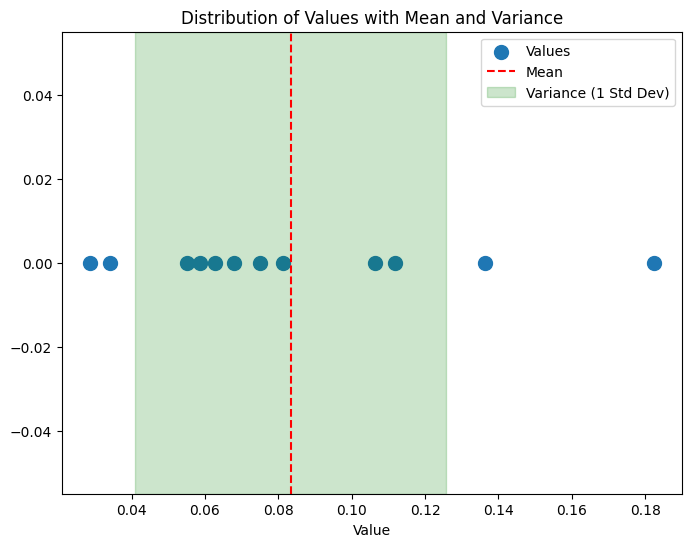

In [ ]:
class_counts_asan=train_split['labels'].value_counts()
class_weights=[0]*num_classes
for class_idx, counts in class_counts_asan.items():
    class_weights[class_idx]=1/(counts/len(train_split))

class_counts_sum=sum(class_weights)
class_weights=[weight/class_counts_sum for weight in class_weights]
class_weights_dict={i:class_weights[i] for i in range(num_classes)}
print(class_weights)
print(sum(class_weights))
thre=np.percentile(class_weights, 75)
print(thre)
print(class_weights>thre)

class_weights_mean=np.mean(class_weights)
class_weights_var=np.var(class_weights)
class_weights_std=np.sqrt(class_weights_var)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(class_weights, [0] * len(class_weights), marker='o', s=100, label='Values') # Plot the 8 values as points
plt.axvline(class_weights_mean, color='r', linestyle='--', label='Mean') # Vertical line for mean
plt.axvspan(class_weights_mean - class_weights_std, class_weights_mean + class_weights_std, color='g', alpha=0.2, label='Variance (1 Std Dev)') # Shaded area for variance
plt.xlabel('Value')
plt.title('Distribution of Values with Mean and Variance')
plt.legend()
plt.show()


In [ ]:
params = {"num_classes": num_classes}

model = Globals.model2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, min_lr=1e-7)
stopper = EarlyStopping(patience=5)
class_sampler=WeightSampler(ISICEmbTrainSet, class_weights)
ISICEmbTrainLoader = torch.utils.data.DataLoader(ISICEmbTrainSet, batch_size=batch_size, collate_fn=ISICEmbTrainSet.collate_fn, sampler=class_sampler)

In [ ]:
params = {"num_classes": num_classes}

model = Globals.model2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, min_lr=1e-7)
stopper = EarlyStopping(patience=5)


In [ ]:
import tqdm

EPOCHS = 40
print_freq = 524


best_valid_loss_isic = float('inf')  # 用于跟踪最佳验证损失
best_valid_loss = float('inf')

for epoch in range(1, EPOCHS+1):


    train_loss, train_accs = [], []


    # code by LYZ:使用 tqdm 来显示训练循环的进度

    for step, batch in tqdm.tqdm(enumerate(ISICEmbTrainLoader, 1), total=len(ISICEmbTrainLoader)):
        time_1 = time.time()

        loss, accuracy = train_one_batch(batch, model, criterion, optimizer)

        train_loss.append(loss)
        train_accs.append(accuracy)


        if step % print_freq == 0:
            print('epoch:', epoch,
                '\tstep:', step, '/', len(ISICEmbTrainLoader),
                '\ttrain loss:', '{:.4f}'.format(loss),
                '\ttrain loss current ep:', '{:.4f}'.format(loss),
                '\ttrain accuracy:','{:.4f}'.format(accuracy),
                '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')



    valid_loss, valid_accs, valid_scores, valid_preds,valid_true = [], [], [], [], []
    for step, batch in enumerate(tqdm.tqdm(ISICEmbValLoader)):
            loss, accuracy, y_scores, y_preds, y_true = validate_one_batch(batch, model, criterion)

            valid_loss.append(loss)
            valid_accs.append(accuracy)
            valid_scores.append(y_scores)
            valid_true.append(y_true)
            valid_preds.append(y_preds)

    valid_scores=np.concatenate(valid_scores)
    valid_true=np.concatenate(valid_true)
    valid_preds=np.concatenate(valid_preds)


    if epoch%2==1:
        f1_weights, f1_scores=calc_f1_weights(model, asan_valid_embs, asan_valid_labels, 12)
    elif epoch%2==0:
        f1_weights, f1_scores=calc_f1_weights(model, asan_valid_embs, asan_valid_labels, 12)
        f1_weights=class_weights

    f1_weights, f1_scores=calc_f1_weights(model, asan_valid_embs, asan_valid_labels, 12)
    f1_weights=class_weights
    weighted_sampler=WeightSampler(data=ISICEmbTrainSet, weights=f1_weights)
    ISICWeightLoader=torch.utils.data.DataLoader(ISICEmbTrainSet, batch_size=batch_size, collate_fn=ISICEmbTrainSet.collate_fn,
                                                       sampler=weighted_sampler)
    print("f1 weights: {}".format(f1_weights))
    print("f1 scores: {}".format(f1_scores))

    print('epoch:', epoch, '/', EPOCHS,
            '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
            '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
            '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
            '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))
    if np.mean(valid_loss) < best_valid_loss:
                best_valid_loss = np.mean(valid_loss)
                checkpoint_path = '/content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth'
                torch.save(model.state_dict(), checkpoint_path)
                print(f'Model weights saved to {checkpoint_path}')

    stopper(np.mean(valid_loss), model)
    scheduler.step(np.mean(valid_loss))

test_loss_isic, test_accs_isic = [], []
for step, batch in enumerate(tqdm.tqdm(ISICEmbTestLoader)):
    loss, accuracy, y_scores, y_preds, y_true = validate_one_batch(batch, model, criterion)

    test_loss_isic.append(loss)
    test_accs_isic.append(accuracy)

print('\ttest loss ISIC :', '{:.4f}'.format(np.mean(test_loss_isic)),
      '\ttest accuracy ISIC', '{:.4f}'.format(np.mean(test_accs_isic)))

100%|██████████| 34/34 [00:01<00:00, 28.84it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.27732173 0.53676167 0.63963964 0.         0.         0.60911704
 0.48962678 0.73668895 0.40151515 0.20706076 0.         0.57643306]
epoch: 1 / 40 	train loss: 5.7207 	valid loss: 2.0297 	train accuracy 0.1714 	valid accuracy 0.4940
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 2.0297


100%|██████████| 34/34 [00:01<00:00, 30.64it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.27603383 0.55620155 0.79912559 0.         0.         0.54181637
 0.55776674 0.77114793 0.47278885 0.48703905 0.08794466 0.62537588]
epoch: 2 / 40 	train loss: 4.2174 	valid loss: 1.8967 	train accuracy 0.2880 	valid accuracy 0.5499
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.8967


100%|██████████| 34/34 [00:01<00:00, 31.70it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.28151709 0.60600304 0.79188865 0.         0.02380952 0.54399483
 0.61164421 0.78645224 0.4954997  0.54117687 0.14563697 0.62962596]
epoch: 3 / 40 	train loss: 3.6158 	valid loss: 1.8194 	train accuracy 0.3642 	valid accuracy 0.5710
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.8194


100%|██████████| 34/34 [00:01<00:00, 30.92it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.15795455 0.58624791 0.81061745 0.         0.06521739 0.52458057
 0.62958604 0.7765078  0.52644078 0.53503205 0.15036232 0.64147049]
epoch: 4 / 40 	train loss: 3.1994 	valid loss: 1.7749 	train accuracy 0.4043 	valid accuracy 0.5729
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.7749


100%|██████████| 34/34 [00:01<00:00, 30.33it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.19951617 0.60533477 0.77667781 0.         0.06926407 0.58621795
 0.62214973 0.78550865 0.52717391 0.52194444 0.32566952 0.65698997]
epoch: 5 / 40 	train loss: 2.8511 	valid loss: 1.6700 	train accuracy 0.4420 	valid accuracy 0.5866
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.6700


100%|██████████| 34/34 [00:01<00:00, 30.24it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.20629085 0.62541655 0.78043167 0.         0.23879813 0.61787323
 0.63063937 0.80287553 0.52906926 0.54881369 0.34807596 0.66970127]
epoch: 6 / 40 	train loss: 2.6513 	valid loss: 1.5520 	train accuracy 0.4650 	valid accuracy 0.6059
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.5520


100%|██████████| 34/34 [00:01<00:00, 30.01it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.18431373 0.62347201 0.77580825 0.         0.19724257 0.62511007
 0.65942994 0.7976744  0.53957265 0.53532666 0.3369709  0.67578918]
epoch: 7 / 40 	train loss: 2.4948 	valid loss: 1.5314 	train accuracy 0.4753 	valid accuracy 0.6023
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.5314


100%|██████████| 34/34 [00:01<00:00, 31.31it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.1879902  0.61159057 0.79222266 0.02631579 0.29022989 0.59514291
 0.64553041 0.80396287 0.53030037 0.55607778 0.38664204 0.69170507]
epoch: 8 / 40 	train loss: 2.3656 	valid loss: 1.4906 	train accuracy 0.4946 	valid accuracy 0.6123
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.4906


100%|██████████| 34/34 [00:01<00:00, 29.72it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.25816993 0.618402   0.80258865 0.10526316 0.39375    0.61228956
 0.65104167 0.80776018 0.58736559 0.55980458 0.43094607 0.68734295]
epoch: 9 / 40 	train loss: 2.2101 	valid loss: 1.4223 	train accuracy 0.5096 	valid accuracy 0.6270
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.4223


100%|██████████| 34/34 [00:01<00:00, 31.50it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.25816993 0.65238363 0.8115104  0.12894737 0.42196782 0.6003848
 0.6499309  0.80453213 0.55055995 0.59930941 0.3995349  0.68675445]
epoch: 10 / 40 	train loss: 2.1693 	valid loss: 1.4172 	train accuracy 0.5139 	valid accuracy 0.6307
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.4172


100%|██████████| 34/34 [00:01<00:00, 30.81it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.27777778 0.63870171 0.80680636 0.12894737 0.39393939 0.58207361
 0.64216294 0.80867117 0.55473443 0.57149246 0.44964588 0.7020748 ]
epoch: 11 / 40 	train loss: 1.9901 	valid loss: 1.4001 	train accuracy 0.5355 	valid accuracy 0.6307
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.4001


100%|██████████| 34/34 [00:01<00:00, 31.22it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.23427288 0.65205334 0.81387707 0.15263158 0.45996875 0.63007722
 0.66177035 0.81163369 0.54931373 0.57416848 0.49725379 0.71760646]
epoch: 12 / 40 	train loss: 1.9244 	valid loss: 1.3076 	train accuracy 0.5434 	valid accuracy 0.6416
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.3076


100%|██████████| 34/34 [00:01<00:00, 32.15it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.19007353 0.64673124 0.80977079 0.15131579 0.4530576  0.61626941
 0.66923034 0.82018142 0.55814853 0.57664236 0.53227162 0.72155148]
epoch: 13 / 40 	train loss: 1.8559 	valid loss: 1.3132 	train accuracy 0.5511 	valid accuracy 0.6434
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 30.47it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.20955882 0.66076728 0.81592247 0.29507576 0.4716842  0.61776574
 0.67876807 0.81774034 0.6462094  0.58526771 0.43771044 0.70620028]
epoch: 14 / 40 	train loss: 1.7664 	valid loss: 1.2056 	train accuracy 0.5623 	valid accuracy 0.6490
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.2056


100%|██████████| 34/34 [00:01<00:00, 29.49it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.26164216 0.65645707 0.81068391 0.21580087 0.46580054 0.63241758
 0.67121171 0.816848   0.59512516 0.59035409 0.45344828 0.71481939]
epoch: 15 / 40 	train loss: 1.6681 	valid loss: 1.2305 	train accuracy 0.5731 	valid accuracy 0.6472
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 29.45it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.24080882 0.66785977 0.80142037 0.25600414 0.47358798 0.67066629
 0.6763751  0.82259066 0.60557416 0.5843977  0.48902606 0.71714601]
epoch: 16 / 40 	train loss: 1.6395 	valid loss: 1.2342 	train accuracy 0.5784 	valid accuracy 0.6536
INFO: Early stopping counter 2 of 5


100%|██████████| 34/34 [00:01<00:00, 31.46it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.28941993 0.65928601 0.8019983  0.25275739 0.43545752 0.66067538
 0.67330898 0.81778832 0.66911977 0.6121015  0.44735023 0.70619806]
epoch: 17 / 40 	train loss: 1.6008 	valid loss: 1.1848 	train accuracy 0.5850 	valid accuracy 0.6527
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.1848


100%|██████████| 34/34 [00:01<00:00, 30.02it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.30902778 0.67294118 0.81353428 0.27489177 0.49555155 0.66067538
 0.6694836  0.81901786 0.64577261 0.62633627 0.56605976 0.7249605 ]
epoch: 18 / 40 	train loss: 1.4815 	valid loss: 1.1627 	train accuracy 0.6020 	valid accuracy 0.6675
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.1627


100%|██████████| 34/34 [00:01<00:00, 31.61it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.31849845 0.67541883 0.80319499 0.34815547 0.51262626 0.67154197
 0.68608507 0.81770031 0.65315904 0.61062809 0.59161287 0.73898169]
epoch: 19 / 40 	train loss: 1.4434 	valid loss: 1.1199 	train accuracy 0.6145 	valid accuracy 0.6738
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.1199


100%|██████████| 34/34 [00:01<00:00, 29.64it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.35212418 0.69122807 0.81237374 0.2987013  0.46796398 0.65168845
 0.69280293 0.8311155  0.63792421 0.62299784 0.58141941 0.74240426]
epoch: 20 / 40 	train loss: 1.4054 	valid loss: 1.1200 	train accuracy 0.6192 	valid accuracy 0.6765
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 30.87it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.39444444 0.69259219 0.80316257 0.39838509 0.42733304 0.68007284
 0.68794643 0.81258344 0.66319678 0.6138306  0.55142433 0.72627524]
epoch: 21 / 40 	train loss: 1.3318 	valid loss: 1.0749 	train accuracy 0.6271 	valid accuracy 0.6692
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.0749


100%|██████████| 34/34 [00:01<00:00, 30.86it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.32116597 0.70409387 0.8145014  0.40307971 0.43577286 0.66316076
 0.71777695 0.82634538 0.70547619 0.63412803 0.55750617 0.74134581]
epoch: 22 / 40 	train loss: 1.3082 	valid loss: 1.0729 	train accuracy 0.6348 	valid accuracy 0.6812
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.0729


100%|██████████| 34/34 [00:01<00:00, 29.66it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.30514706 0.72905303 0.80802591 0.4775641  0.49523026 0.67740754
 0.7470931  0.83683418 0.64880952 0.65008835 0.56146305 0.74839327]
epoch: 23 / 40 	train loss: 1.2710 	valid loss: 1.0609 	train accuracy 0.6437 	valid accuracy 0.6931
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.0609


100%|██████████| 34/34 [00:01<00:00, 29.42it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.40324296 0.73922902 0.80801807 0.51388889 0.45140056 0.67490688
 0.7265265  0.82163692 0.68375    0.64790071 0.56586224 0.75436508]
epoch: 24 / 40 	train loss: 1.2361 	valid loss: 1.0417 	train accuracy 0.6601 	valid accuracy 0.6913
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.0417


100%|██████████| 34/34 [00:01<00:00, 31.13it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.43967627 0.74373446 0.80742332 0.4957265  0.53201312 0.71417069
 0.68763379 0.83000467 0.67927632 0.63851761 0.60620555 0.75345994]
epoch: 25 / 40 	train loss: 1.1839 	valid loss: 1.0203 	train accuracy 0.6582 	valid accuracy 0.6996
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 1.0203


100%|██████████| 34/34 [00:01<00:00, 30.83it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.39766082 0.71247648 0.80367936 0.49038462 0.47377277 0.71314103
 0.64812834 0.82983978 0.67568738 0.62407783 0.63211754 0.74941687]
epoch: 26 / 40 	train loss: 1.1345 	valid loss: 1.0290 	train accuracy 0.6678 	valid accuracy 0.6894
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 30.74it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.36990962 0.7431699  0.81281028 0.45806763 0.52611789 0.74004516
 0.72011396 0.85101203 0.67299258 0.64150789 0.58062509 0.73968204]
epoch: 27 / 40 	train loss: 1.1095 	valid loss: 0.9887 	train accuracy 0.6740 	valid accuracy 0.7006
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 0.9887


100%|██████████| 34/34 [00:01<00:00, 31.04it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.32107843 0.7330007  0.79060015 0.53703704 0.48707808 0.72213837
 0.64473962 0.82423847 0.61652237 0.63658212 0.59090354 0.74181319]
epoch: 28 / 40 	train loss: 1.0543 	valid loss: 1.0398 	train accuracy 0.6893 	valid accuracy 0.6866
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 30.29it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.37061404 0.73239135 0.78765738 0.51322751 0.49435157 0.73419384
 0.67911022 0.82049097 0.69719298 0.65892807 0.61483987 0.74509839]
epoch: 29 / 40 	train loss: 1.0375 	valid loss: 0.9903 	train accuracy 0.6998 	valid accuracy 0.6931
INFO: Early stopping counter 2 of 5


100%|██████████| 34/34 [00:01<00:00, 30.80it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.36332952 0.71665303 0.82198109 0.4531339  0.47534702 0.72169384
 0.70681388 0.82575534 0.6625817  0.64388121 0.61706349 0.76395176]
epoch: 30 / 40 	train loss: 0.9813 	valid loss: 0.9920 	train accuracy 0.7037 	valid accuracy 0.6913
INFO: Early stopping counter 3 of 5


100%|██████████| 34/34 [00:01<00:00, 30.16it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.40543478 0.72803733 0.80430195 0.49430199 0.4729021  0.7540293
 0.67031359 0.83518815 0.63456767 0.64564417 0.5871345  0.75282356]
epoch: 31 / 40 	train loss: 0.9787 	valid loss: 1.0155 	train accuracy 0.7074 	valid accuracy 0.6931
INFO: Early stopping counter 4 of 5


100%|██████████| 34/34 [00:01<00:00, 30.94it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.48916667 0.73458875 0.80286561 0.58127623 0.55155855 0.71282574
 0.70413893 0.84774288 0.71409774 0.6769394  0.65461191 0.74563254]
epoch: 32 / 40 	train loss: 0.9460 	valid loss: 0.9548 	train accuracy 0.7150 	valid accuracy 0.7170
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 0.9548


100%|██████████| 34/34 [00:01<00:00, 31.90it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.46293706 0.75404975 0.80851294 0.5702381  0.49194501 0.68897436
 0.74208174 0.84226404 0.71961862 0.66403639 0.65074278 0.74864181]
epoch: 33 / 40 	train loss: 0.9330 	valid loss: 0.9523 	train accuracy 0.7238 	valid accuracy 0.7124
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 0.9523


100%|██████████| 34/34 [00:01<00:00, 31.34it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.52268167 0.73510597 0.82254536 0.63809524 0.58478121 0.65670788
 0.73095238 0.842332   0.71875    0.6841608  0.60834974 0.75849598]
epoch: 34 / 40 	train loss: 0.9084 	valid loss: 0.9547 	train accuracy 0.7257 	valid accuracy 0.7198
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 29.75it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.52222777 0.76666667 0.82189992 0.68854283 0.56162113 0.67379121
 0.76418509 0.85635136 0.7655628  0.6995043  0.61325101 0.76891443]
epoch: 35 / 40 	train loss: 0.8802 	valid loss: 0.9330 	train accuracy 0.7351 	valid accuracy 0.7344
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval_3.pth with validation loss: 0.9330


100%|██████████| 34/34 [00:01<00:00, 30.31it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.41188198 0.7387308  0.80207276 0.6545977  0.56855159 0.69772257
 0.71206897 0.84911987 0.7487395  0.69685487 0.61961984 0.75497754]
epoch: 36 / 40 	train loss: 0.8577 	valid loss: 0.9574 	train accuracy 0.7378 	valid accuracy 0.7208
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 27.91it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.48768661 0.7523994  0.81284556 0.64687101 0.55334767 0.6852381
 0.73859697 0.84932928 0.72969949 0.68948283 0.63093276 0.77801822]
epoch: 37 / 40 	train loss: 0.8699 	valid loss: 0.9673 	train accuracy 0.7345 	valid accuracy 0.7281
INFO: Early stopping counter 2 of 5


100%|██████████| 34/34 [00:01<00:00, 28.86it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.5482684  0.76403162 0.80419014 0.66757508 0.54510685 0.69215738
 0.75689655 0.84037286 0.74824883 0.67382935 0.6391779  0.75877546]
epoch: 38 / 40 	train loss: 0.8360 	valid loss: 0.9458 	train accuracy 0.7489 	valid accuracy 0.7271
INFO: Early stopping counter 3 of 5


100%|██████████| 34/34 [00:01<00:00, 27.78it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.50365982 0.72767775 0.84135598 0.62913075 0.53354583 0.67427064
 0.7676975  0.84634817 0.78011696 0.66156884 0.63784315 0.7714134 ]
epoch: 39 / 40 	train loss: 0.8314 	valid loss: 0.9671 	train accuracy 0.7470 	valid accuracy 0.7235
INFO: Early stopping counter 4 of 5


100%|██████████| 34/34 [00:01<00:00, 28.64it/s]


f1 weights: [0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
f1 scores: [0.54761905 0.76101165 0.81719338 0.65029762 0.54110679 0.6615083
 0.76657825 0.85256522 0.79440267 0.68732666 0.63748144 0.75867996]
epoch: 40 / 40 	train loss: 0.8171 	valid loss: 0.9495 	train accuracy 0.7500 	valid accuracy 0.7317
INFO: Early stopping counter 5 of 5
INFO: Early stopping


100%|██████████| 40/40 [00:01<00:00, 31.56it/s]

	test loss ISIC : 1.0783 	test accuracy ISIC 0.6883


In [ ]:
test accuracy ISIC 0.6788
train accuracy 0.9130 	valid accuracy 0.7574

In [ ]:
for name, param in model.named_parameters():
    print(f"Parameter: {name}, Data type: {param.dtype}")

Parameter: fc1.weight, Data type: torch.float64
Parameter: fc1.bias, Data type: torch.float64
Parameter: batchNorm1.weight, Data type: torch.float64
Parameter: batchNorm1.bias, Data type: torch.float64
Parameter: fc2.weight, Data type: torch.float64
Parameter: fc2.bias, Data type: torch.float64
Parameter: batchNorm2.weight, Data type: torch.float64
Parameter: batchNorm2.bias, Data type: torch.float64
Parameter: fc3.weight, Data type: torch.float64
Parameter: fc3.bias, Data type: torch.float64
Parameter: batchNorm3.weight, Data type: torch.float64
Parameter: batchNorm3.bias, Data type: torch.float64
Parameter: fc4.weight, Data type: torch.float64
Parameter: fc4.bias, Data type: torch.float64
Parameter: batchNorm4.weight, Data type: torch.float64
Parameter: batchNorm4.bias, Data type: torch.float64
Parameter: fc5.weight, Data type: torch.float64
Parameter: fc5.bias, Data type: torch.float64
Parameter: batchNorm5.weight, Data type: torch.float64
Parameter: batchNorm5.bias, Data type: torc

In [ ]:
import tqdm

EPOCHS = 40
print_freq = 524


best_valid_loss_isic = float('inf')  # 用于跟踪最佳验证损失
best_valid_loss = float('inf')

for epoch in range(1, EPOCHS+1):


    train_loss, train_accs = [], []


    # code by LYZ:使用 tqdm 来显示训练循环的进度

    for step, batch in tqdm.tqdm(enumerate(ISICEmbTrainLoader, 1), total=len(ISICEmbTrainLoader)):
        time_1 = time.time()

        loss, accuracy = train_one_batch(batch, model, criterion, optimizer)

        train_loss.append(loss)
        train_accs.append(accuracy)


        if step % print_freq == 0:
            print('epoch:', epoch,
                '\tstep:', step, '/', len(ISICEmbTrainLoader),
                '\ttrain loss:', '{:.4f}'.format(loss),
                '\ttrain loss current ep:', '{:.4f}'.format(loss),
                '\ttrain accuracy:','{:.4f}'.format(accuracy),
                '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')



    valid_loss, valid_accs, valid_scores, valid_preds,valid_true = [], [], [], [], []
    for step, batch in enumerate(tqdm.tqdm(ISICEmbValLoader)):
        loss, accuracy, y_scores, y_preds, y_true = validate_one_batch(batch, model, criterion)

        valid_loss.append(loss)
        valid_accs.append(accuracy)
        valid_scores.append(y_scores)
        valid_true.append(y_true)
        valid_preds.append(y_preds)

    valid_scores=np.concatenate(valid_scores)
    valid_true=np.concatenate(valid_true)
    valid_preds=np.concatenate(valid_preds)

    print('epoch:', epoch, '/', EPOCHS,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
          '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
          '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))
    if np.mean(valid_loss) < best_valid_loss:
            best_valid_loss = np.mean(valid_loss)
            checkpoint_path = '/content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model weights saved to {checkpoint_path}')

    stopper(np.mean(valid_loss), model)
    scheduler.step(np.mean(valid_loss))

test_loss_isic, test_accs_isic = [], []
for step, batch in enumerate(tqdm.tqdm(ISICEmbTestLoader)):
    loss, accuracy, y_scores, y_preds, y_true = validate_one_batch(batch, model, criterion)

    test_loss_isic.append(loss)
    test_accs_isic.append(accuracy)

print('\ttest loss ISIC :', '{:.4f}'.format(np.mean(test_loss_isic)),
      '\ttest accuracy ISIC', '{:.4f}'.format(np.mean(test_accs_isic)))

100%|██████████| 34/34 [00:01<00:00, 31.51it/s]


epoch: 1 / 40 	train loss: 6.0666 	valid loss: 1.8655 	train accuracy 0.1564 	valid accuracy 0.5372
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.8655


100%|██████████| 34/34 [00:01<00:00, 32.22it/s]


epoch: 2 / 40 	train loss: 4.7512 	valid loss: 1.8087 	train accuracy 0.2503 	valid accuracy 0.5757
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.8087


100%|██████████| 34/34 [00:01<00:00, 28.22it/s]


epoch: 3 / 40 	train loss: 4.0496 	valid loss: 1.7143 	train accuracy 0.3158 	valid accuracy 0.6142
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.7143


100%|██████████| 34/34 [00:01<00:00, 32.87it/s]


epoch: 4 / 40 	train loss: 3.7087 	valid loss: 1.6846 	train accuracy 0.3510 	valid accuracy 0.6243
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.6846


100%|██████████| 34/34 [00:01<00:00, 33.61it/s]


epoch: 5 / 40 	train loss: 3.3736 	valid loss: 1.6099 	train accuracy 0.3767 	valid accuracy 0.6371
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.6099


100%|██████████| 34/34 [00:01<00:00, 31.79it/s]


epoch: 6 / 40 	train loss: 3.2304 	valid loss: 1.5479 	train accuracy 0.3951 	valid accuracy 0.6518
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.5479


100%|██████████| 34/34 [00:01<00:00, 33.37it/s]


epoch: 7 / 40 	train loss: 2.9919 	valid loss: 1.4585 	train accuracy 0.4222 	valid accuracy 0.6583
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.4585


100%|██████████| 34/34 [00:01<00:00, 29.77it/s]


epoch: 8 / 40 	train loss: 2.8239 	valid loss: 1.4322 	train accuracy 0.4451 	valid accuracy 0.6711
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.4322


100%|██████████| 34/34 [00:01<00:00, 33.07it/s]


epoch: 9 / 40 	train loss: 2.7139 	valid loss: 1.4581 	train accuracy 0.4443 	valid accuracy 0.6683
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 31.69it/s]


epoch: 10 / 40 	train loss: 2.6022 	valid loss: 1.3014 	train accuracy 0.4584 	valid accuracy 0.6803
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.3014


100%|██████████| 34/34 [00:01<00:00, 32.43it/s]


epoch: 11 / 40 	train loss: 2.4792 	valid loss: 1.3191 	train accuracy 0.4722 	valid accuracy 0.6782
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 32.92it/s]


epoch: 12 / 40 	train loss: 2.3744 	valid loss: 1.2267 	train accuracy 0.4819 	valid accuracy 0.7004
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.2267


100%|██████████| 34/34 [00:01<00:00, 33.05it/s]


epoch: 13 / 40 	train loss: 2.2651 	valid loss: 1.2427 	train accuracy 0.4929 	valid accuracy 0.6866
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 33.89it/s]


epoch: 14 / 40 	train loss: 2.1633 	valid loss: 1.1801 	train accuracy 0.5093 	valid accuracy 0.7006
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.1801


100%|██████████| 34/34 [00:01<00:00, 33.08it/s]


epoch: 15 / 40 	train loss: 2.1225 	valid loss: 1.1707 	train accuracy 0.5079 	valid accuracy 0.6933
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.1707


100%|██████████| 34/34 [00:01<00:00, 33.28it/s]


epoch: 16 / 40 	train loss: 1.9877 	valid loss: 1.1779 	train accuracy 0.5267 	valid accuracy 0.7023
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 30.31it/s]


epoch: 17 / 40 	train loss: 1.9745 	valid loss: 1.1500 	train accuracy 0.5241 	valid accuracy 0.7051
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.1500


100%|██████████| 34/34 [00:01<00:00, 33.45it/s]


epoch: 18 / 40 	train loss: 1.8698 	valid loss: 1.1222 	train accuracy 0.5435 	valid accuracy 0.7097
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.1222


100%|██████████| 34/34 [00:01<00:00, 32.55it/s]


epoch: 19 / 40 	train loss: 1.8149 	valid loss: 1.1042 	train accuracy 0.5476 	valid accuracy 0.7069
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.1042


100%|██████████| 34/34 [00:01<00:00, 33.44it/s]


epoch: 20 / 40 	train loss: 1.7445 	valid loss: 1.0712 	train accuracy 0.5548 	valid accuracy 0.7198
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.0712


100%|██████████| 34/34 [00:01<00:00, 32.69it/s]


epoch: 21 / 40 	train loss: 1.6868 	valid loss: 1.0459 	train accuracy 0.5631 	valid accuracy 0.7170
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.0459


100%|██████████| 34/34 [00:01<00:00, 33.15it/s]


epoch: 22 / 40 	train loss: 1.6742 	valid loss: 1.0668 	train accuracy 0.5655 	valid accuracy 0.7170
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 31.46it/s]


epoch: 23 / 40 	train loss: 1.5964 	valid loss: 1.0272 	train accuracy 0.5758 	valid accuracy 0.7206
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.0272


100%|██████████| 34/34 [00:01<00:00, 32.27it/s]


epoch: 24 / 40 	train loss: 1.5944 	valid loss: 1.0398 	train accuracy 0.5786 	valid accuracy 0.7170
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 31.62it/s]


epoch: 25 / 40 	train loss: 1.5107 	valid loss: 1.0275 	train accuracy 0.5910 	valid accuracy 0.7216
INFO: Early stopping counter 2 of 5


100%|██████████| 34/34 [00:01<00:00, 31.06it/s]


epoch: 26 / 40 	train loss: 1.4482 	valid loss: 1.0033 	train accuracy 0.5926 	valid accuracy 0.7181
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 1.0033


100%|██████████| 34/34 [00:01<00:00, 30.73it/s]


epoch: 27 / 40 	train loss: 1.4253 	valid loss: 0.9794 	train accuracy 0.5989 	valid accuracy 0.7246
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 0.9794


100%|██████████| 34/34 [00:01<00:00, 31.66it/s]


epoch: 28 / 40 	train loss: 1.3844 	valid loss: 0.9813 	train accuracy 0.6135 	valid accuracy 0.7328
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 31.64it/s]


epoch: 29 / 40 	train loss: 1.3609 	valid loss: 0.9606 	train accuracy 0.6165 	valid accuracy 0.7282
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 0.9606


100%|██████████| 34/34 [00:01<00:00, 32.78it/s]


epoch: 30 / 40 	train loss: 1.3477 	valid loss: 0.9482 	train accuracy 0.6150 	valid accuracy 0.7290
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 0.9482


100%|██████████| 34/34 [00:01<00:00, 32.54it/s]


epoch: 31 / 40 	train loss: 1.2654 	valid loss: 0.9687 	train accuracy 0.6310 	valid accuracy 0.7225
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 32.38it/s]


epoch: 32 / 40 	train loss: 1.2467 	valid loss: 0.9271 	train accuracy 0.6332 	valid accuracy 0.7282
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 0.9271


100%|██████████| 34/34 [00:01<00:00, 32.00it/s]


epoch: 33 / 40 	train loss: 1.2150 	valid loss: 0.9608 	train accuracy 0.6428 	valid accuracy 0.7355
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 29.36it/s]


epoch: 34 / 40 	train loss: 1.1682 	valid loss: 0.9290 	train accuracy 0.6546 	valid accuracy 0.7328
INFO: Early stopping counter 2 of 5


100%|██████████| 34/34 [00:01<00:00, 32.55it/s]


epoch: 35 / 40 	train loss: 1.1610 	valid loss: 0.9213 	train accuracy 0.6542 	valid accuracy 0.7282
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 0.9213


100%|██████████| 34/34 [00:01<00:00, 31.65it/s]


epoch: 36 / 40 	train loss: 1.1061 	valid loss: 0.9209 	train accuracy 0.6704 	valid accuracy 0.7328
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 0.9209


100%|██████████| 34/34 [00:01<00:00, 29.94it/s]


epoch: 37 / 40 	train loss: 1.1224 	valid loss: 0.9313 	train accuracy 0.6649 	valid accuracy 0.7289
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 33.12it/s]


epoch: 38 / 40 	train loss: 1.0696 	valid loss: 0.9122 	train accuracy 0.6802 	valid accuracy 0.7455
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 0.9122


100%|██████████| 34/34 [00:01<00:00, 31.44it/s]


epoch: 39 / 40 	train loss: 1.0585 	valid loss: 0.8919 	train accuracy 0.6823 	valid accuracy 0.7363
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 0.8919


100%|██████████| 34/34 [00:01<00:00, 33.38it/s]


epoch: 40 / 40 	train loss: 1.0345 	valid loss: 0.8724 	train accuracy 0.6878 	valid accuracy 0.7444
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth with validation loss: 0.8724


100%|██████████| 40/40 [00:01<00:00, 33.12it/s]

	test loss ISIC : 1.0960 	test accuracy ISIC 0.6829


In [ ]:
test_loss_isic, test_accs_isic = [], []
for step, batch in enumerate(tqdm.tqdm(ISICEmbTestLoader)):
    loss, accuracy, y_scores, y_preds, y_true = validate_one_batch(batch, Globals.model2, criterion)

    test_loss_isic.append(loss)
    test_accs_isic.append(accuracy)

print('\ttest loss ISIC :', '{:.4f}'.format(np.mean(test_loss_isic)),
      '\ttest accuracy ISIC', '{:.4f}'.format(np.mean(test_accs_isic)))

100%|██████████| 40/40 [00:01<00:00, 31.66it/s]

	test loss ISIC : 2.4927 	test accuracy ISIC 0.0852


In [ ]:
def load_resnet18_model(model, model_path, num_classes=12):
    model = MLP(6144, num_classes)
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # 使用CPU加载模型

    # 获取模型的状态字典
    state_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint

    # 创建一个新的状态字典，只保留与模型匹配的键
    model_state_dict = model.state_dict()
    state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}


    # 加载状态字典到模型中，strict=False 可以处理缺失或意外的键
    model.load_state_dict(state_dict, strict=False)

    model.eval()  # 设置模型为评估模式
    return model

# 用法
model_path = '/content/drive/MyDrive/Swarnava/asanEmb_model_stratifiedval.pth'  # 指向保存的模型检查点的路径
Globals.model1 = load_resnet18_model(Globals.model1,model_path)

<ipython-input-24-259f3798b2b8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # 使用CPU加载模型


In [ ]:
def load_model(model, model_path, num_classes=12):
    model = MLP(embedding_dim, num_classes)
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # 使用CPU加载模型

    # 获取模型的状态字典
    state_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint

    # 创建一个新的状态字典，只保留与模型匹配的键
    model_state_dict = model.state_dict()
    state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}

    # 加载状态字典到模型中，strict=False 可以处理缺失或意外的键
    model.load_state_dict(state_dict, strict=False)

    model.eval()  # 设置模型为评估模式
    return model

# 用法
model_path = '/content/drive/MyDrive/Swarnava/asanEmb_model_unsampled.pth'  # 指向保存的模型检查点的路径
Globals.model2 = load_resnet18_model(Globals.model2,model_path)

<ipython-input-24-259f3798b2b8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # 使用CPU加载模型


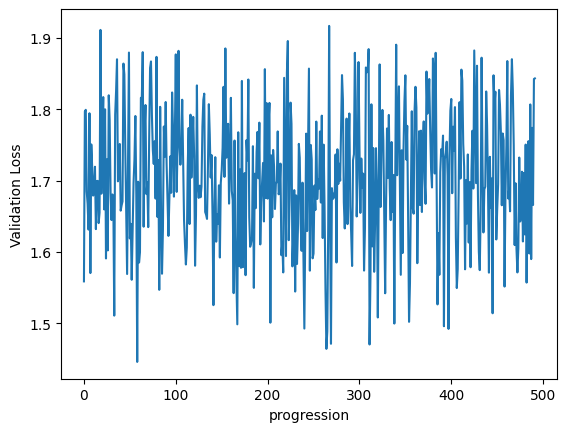

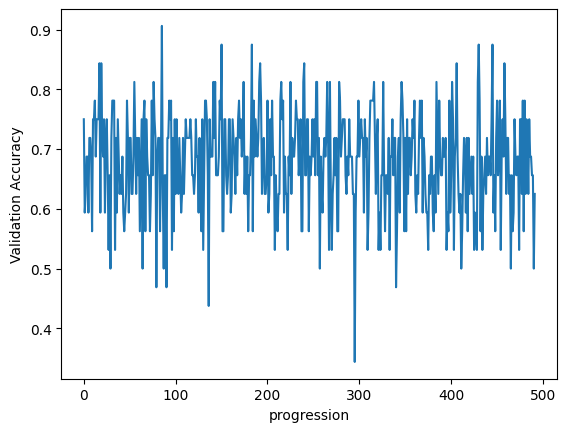

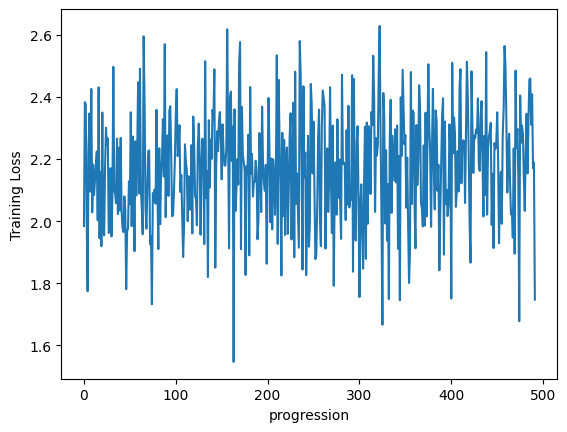

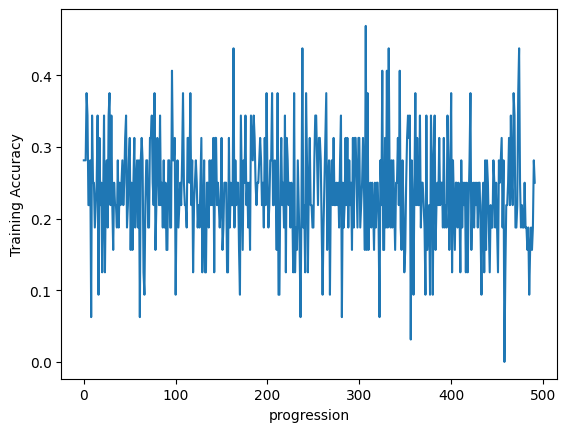

In [ ]:
import matplotlib.pyplot as plt

plt.plot(valid_loss_asan)
plt.xlabel('progression')
plt.ylabel('Validation Loss')
plt.show()

plt.plot(valid_accs_asan)
plt.xlabel('progression')
plt.ylabel('Validation Accuracy')
plt.show()

plt.plot(train_loss_asan)
plt.xlabel('progression')
plt.ylabel('Training Loss')
plt.show()

plt.plot(train_accs_asan)
plt.xlabel('progression')
plt.ylabel('Training Accuracy')
plt.show()

In [ ]:
train 86.34
valid 7177
test 7332

MLP(
  (fc1): Linear(in_features=6144, out_features=2048, bias=True)
  (batchNorm1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): Swish()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (batchNorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): Swish()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (batchNorm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (batchNorm4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (batchNorm5): BatchNorm1d(128, eps=1e-

In [ ]:
for embs, labels in ISICEmbTestLoader2:
    output=softmax_model(embs)
    acc=calc_accuracy(output, labels)
    print(output)
    print(labels)
    print(acc)


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])

In [ ]:
import tqdm
E_scores=[]
calib_labels=[]

softmax_model=MLPwithSoftMax(Globals.model2).eval().to(device)

for emb,label in tqdm.tqdm(ISICEmbCalibLoader):
    emb=emb.to(device)
    output=softmax_model(emb)
    e=output[[0]]
    E_scores.append(e)
    calib_labels.append(label.item())

    emb=emb.cpu()
    del emb
    torch.cuda.empty_cache()




100%|██████████| 985/985 [00:04<00:00, 230.35it/s]


In [ ]:
E_scores=[]

prob_outputs=brf.predict_proba(asan_calib_embs)

for i in range(len(asan_calib_embs)):
    output=prob_outputs[i][asan_calib_labels[i]]
    E_scores.append(output)

print(E_scores)

[0.6230833333333332, 0.5099333333333333, 0.4666, 0.3122499999999999, 0.45358333333333334, 0.14816666666666667, 0.45265, 0.30310000000000004, 0.4651666666666667, 0.33796666666666664, 0.051, 0.6096666666666666, 0.36540000000000006, 0.1835, 0.1448, 0.13165000000000002, 0.08138333333333334, 0.29224999999999995, 0.5448166666666666, 0.08783333333333335, 0.050416666666666665, 0.0965, 0.3765, 0.9419, 0.4345833333333333, 0.19950000000000004, 0.7505, 0.64085, 0.33291666666666664, 0.214, 0.30850000000000005, 0.4394166666666666, 0.19363333333333332, 0.3709333333333333, 0.2695, 0.18566666666666665, 0.22191666666666662, 0.4965, 0.4835833333333333, 0.28391666666666665, 0.4050833333333334, 0.3800833333333334, 0.5083333333333333, 0.86325, 0.9153333333333332, 0.22459999999999997, 0.2495, 0.5759333333333334, 0.2058333333333333, 0.4701666666666667, 0.5434333333333334, 0.15314999999999998, 0.3860833333333333, 0.12683333333333333, 0.4586166666666667, 0.4819333333333333, 0.5589166666666666, 0.37225, 0.567166

In [ ]:
print(len(calib_split))

985


In [ ]:
E_values = [e[0] for e in E_scores]
for i in range(len(E_values)):
    E_scores[i] = (E_values[i][calib_labels[i]])
    print(E_scores[i])

tensor(0.7860, grad_fn=<SelectBackward0>)
tensor(0.9997, grad_fn=<SelectBackward0>)
tensor(0.9364, grad_fn=<SelectBackward0>)
tensor(0.8113, grad_fn=<SelectBackward0>)
tensor(0.8394, grad_fn=<SelectBackward0>)
tensor(0.3937, grad_fn=<SelectBackward0>)
tensor(0.9997, grad_fn=<SelectBackward0>)
tensor(0.7277, grad_fn=<SelectBackward0>)
tensor(0.6061, grad_fn=<SelectBackward0>)
tensor(0.9878, grad_fn=<SelectBackward0>)
tensor(0.0249, grad_fn=<SelectBackward0>)
tensor(0.9998, grad_fn=<SelectBackward0>)
tensor(0.8565, grad_fn=<SelectBackward0>)
tensor(0.4799, grad_fn=<SelectBackward0>)
tensor(0.0388, grad_fn=<SelectBackward0>)
tensor(0.4198, grad_fn=<SelectBackward0>)
tensor(0.0119, grad_fn=<SelectBackward0>)
tensor(0.9991, grad_fn=<SelectBackward0>)
tensor(0.9792, grad_fn=<SelectBackward0>)
tensor(0.1646, grad_fn=<SelectBackward0>)
tensor(0.0091, grad_fn=<SelectBackward0>)
tensor(0.0798, grad_fn=<SelectBackward0>)
tensor(0.8914, grad_fn=<SelectBackward0>)
tensor(1.0000, grad_fn=<SelectBack

In [ ]:
print(len(asan_calib_embs))

985


In [ ]:
import math
E_scores = torch.tensor(E_scores)
E_sorted, _ = torch.sort(E_scores)
q_hat = math.ceil((986)*0.70)/985
E_10 = torch.quantile(E_sorted, q_hat)
print(E_10)
print(E_sorted)

tensor(0.9810)
tensor([1.9222e-05, 1.1489e-04, 2.0650e-04, 2.7808e-04, 4.5507e-04, 4.9169e-04,
        6.4409e-04, 6.9687e-04, 1.2256e-03, 1.2968e-03, 1.3849e-03, 1.5237e-03,
        2.4870e-03, 3.1144e-03, 3.6091e-03, 3.7388e-03, 3.9051e-03, 4.4632e-03,
        4.8204e-03, 5.7222e-03, 5.7888e-03, 6.0428e-03, 6.4578e-03, 7.0186e-03,
        7.0814e-03, 7.2798e-03, 7.3395e-03, 7.4616e-03, 7.7354e-03, 7.8395e-03,
        8.7765e-03, 8.8667e-03, 9.0639e-03, 1.0281e-02, 1.0791e-02, 1.1784e-02,
        1.1907e-02, 1.2685e-02, 1.3403e-02, 1.3524e-02, 1.4113e-02, 1.4216e-02,
        1.4678e-02, 1.4972e-02, 1.8318e-02, 1.8538e-02, 1.8855e-02, 2.0026e-02,
        2.0289e-02, 2.1245e-02, 2.1496e-02, 2.1530e-02, 2.2179e-02, 2.3021e-02,
        2.3033e-02, 2.3834e-02, 2.4272e-02, 2.4938e-02, 2.5921e-02, 2.5969e-02,
        2.6084e-02, 2.8499e-02, 2.8532e-02, 3.1533e-02, 3.2111e-02, 3.2600e-02,
        3.2677e-02, 3.4830e-02, 3.5130e-02, 3.5554e-02, 3.6351e-02, 3.6867e-02,
        3.7264e-02, 3.764

In [ ]:
test=torch.tensor([0.2, 0.4, 0.1, 0.8, 0.3])

s_1, s_2=torch.sort(test, descending=True)
print(s_1)
print(s_2)

tensor([0.8000, 0.4000, 0.3000, 0.2000, 0.1000])
tensor([3, 1, 4, 0, 2])


In [ ]:
label_sets = {num: dict() for num in range(len(test_data))}
count = 0
for emb,label in tqdm.tqdm(ISICEmbTestLoader2):
    emb = emb.to(device)
    output = softmax_model(emb)
    sorted_output, indices = torch.sort(output[0], dim=0, descending=True)
    sum=0
    for i in range(len(sorted_output)):
        if(sum<E_10):
            sum+=output[0][i]
            label_sets[count][indices[i].item()]=sorted_output[i].item()
    count+=1

100%|██████████| 1274/1274 [00:05<00:00, 226.66it/s]


[4.00529335e-07 7.54223709e-06 3.43619090e-05 ... 9.99999632e-01
 9.99999666e-01 9.99999974e-01]


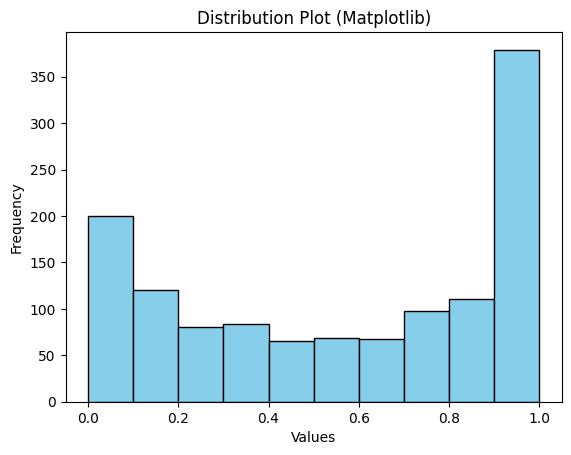

In [ ]:
t1 = Globals.model1.predict_proba(asan_test_embs)
t2 = np.array([])

for i in range(len(t1)):
    #print(t1[i][asan_test_labels[i]])
    t2 = np.append(t2, t1[i][asan_test_labels[i]])

t2=np.sort(t2)
print(t2)
plt.hist(t2, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution Plot (Matplotlib)')
plt.show()

In [ ]:
label_sets = {num: set() for num in range(len(test_data))}
count = 0

for i in range(len(asan_test_embs)):
    input=asan_test_embs[i].reshape(1,6144)
    output = np.flip(np.sort(brf.predict_proba(input)))
    sum=0


    for j in range(len(output[0])):
        if(sum<E_10):
            sum+=output[0][j]
            label_sets[count].add(j)
    count+=1

In [ ]:
for label_set in label_sets.values():
    print(label_set)

{0, 1, 2}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3}
{0, 1, 2, 3}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4}
{0, 1, 2, 3}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4}
{0, 1, 2}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3}
{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3}
{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4, 5}
{0, 1, 2}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2}
{0, 1, 2, 3}
{0, 1, 2, 3, 4, 5, 

In [ ]:
print(label_sets)

difficulty_index_1 = []
difficulty_index_2 = []
difficulty_index_3 = []
difficulty_index_4 = []
empty = []

count=0
empty_count=0
for label_set in label_sets.values():
    if(len(label_set.keys())==1):
        difficulty_index_1.append(count)
    count+=1

for label_set in label_sets.values():
    if(len(label_set.keys())==2):
        difficulty_index_2.append(count)
    count+=1

for label_set in label_sets.values():
    if(len(label_set.keys())==3):
        difficulty_index_3.append(count)
    count+=1

for label_set in label_sets.values():
    if(len(label_set.keys())>3):
        difficulty_index_4.append(count)
    count+=1

for label_set in label_sets.values():
    if(len(label_set.keys())==0):
        empty.append(empty_count)
    empty_count+=1
print(len(difficulty_index_1))
print(len(difficulty_index_2))
print(len(difficulty_index_3))
print(len(difficulty_index_4))
print(len(empty))



{0: {9: 0.7735352516174316, 4: 0.17507806420326233, 0: 0.024771297350525856, 1: 0.006865207571536303, 11: 0.004936443641781807, 10: 0.004214963410049677, 6: 0.003645312273874879, 3: 0.0031832754611968994, 8: 0.002680805278941989, 5: 0.0005335674504749477}, 1: {0: 0.49676546454429626, 5: 0.42320504784584045, 4: 0.04460427537560463, 10: 0.014388274401426315, 11: 0.005133156664669514, 9: 0.004956628195941448, 6: 0.004726944491267204, 3: 0.002083607716485858, 1: 0.0018883548909798265, 7: 0.0010647305753082037, 2: 0.0008729482651688159}, 2: {0: 0.9090933799743652, 4: 0.04464046284556389, 9: 0.0210416316986084, 5: 0.0115083958953619, 3: 0.004941544495522976, 11: 0.0025130356661975384, 10: 0.001947699929587543, 1: 0.0019340887665748596, 6: 0.0014887404395267367, 7: 0.0004028608091175556}, 3: {2: 0.4028395414352417, 4: 0.15745484828948975, 3: 0.1256626397371292, 11: 0.1173514798283577, 0: 0.05363379791378975, 5: 0.05007714778184891, 10: 0.035023678094148636, 7: 0.029544813558459282, 9: 0.01045

In [ ]:
label_set_lengths={i:0 for i in range(num_classes)}
for label_set in label_sets.values():
    label_set_lengths[len(label_set)-1]+=1
print(label_set_lengths)


{0: 0, 1: 19, 2: 82, 3: 31, 4: 16, 5: 31, 6: 35, 7: 156, 8: 66, 9: 187, 10: 136, 11: 515}


In [ ]:
good_pred_set=0
for i in range(len(asan_test_embs)):
    if asan_test_labels[i] in label_sets[i].keys():
        good_pred_set+=1
print(good_pred_set)
print(len(asan_test_embs))

1268
1274


In [ ]:
good_pred_set_2=0
for i in range(len(asan_test_embs)):
    if asan_test_labels[i] in label_sets[i].keys():
        label_conf=label_sets[i][asan_test_labels[i]]
    else:
        print("Wrong prediction")
        continue
    print(label_conf)
    if label_conf==max(label_sets[i].values()):
        good_pred_set_2+=1
print(good_pred_set_2)
print(len(asan_test_embs))

0.024771297350525856
0.49676546454429626
0.9090933799743652
0.05363379791378975
0.035012923181056976
0.046871721744537354
0.5705183148384094
0.6807405948638916
0.8110778331756592
0.9125398993492126
0.7297864556312561
0.23307883739471436
0.9476480484008789
0.8702492713928223
0.7796334624290466
0.4752064347267151
Wrong prediction
0.7344832420349121
0.15055252611637115
0.7831764221191406
0.48842865228652954
0.5566624999046326
0.7993693947792053
0.46838369965553284
0.8869852423667908
0.14698877930641174
0.8132695555686951
0.9030725359916687
0.23745188117027283
0.9229487180709839
0.8612017631530762
0.017933866009116173
0.39857444167137146
0.9498980045318604
0.09143619239330292
0.7720571756362915
0.6957645416259766
0.013958978466689587
0.1370326578617096
0.6003002524375916
0.0943838432431221
0.061884161084890366
0.6402397751808167
0.008360178209841251
0.6052150130271912
0.7687596678733826
0.001970120705664158
0.711936354637146
0.908153235912323
0.1784895360469818
0.08965614438056946
0.331749

166
254
250
1777
0
340
395
331
1381
0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from matplotlib.backends.backend_pdf import PdfPages

def plot_multiclass_roc(y_true, y_score, num_classes, class_names, pdf_filename):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class')
    plt.legend(loc="lower right")

    # 保存为PDF
    pdf_pages = PdfPages(pdf_filename)
    pdf_pages.savefig()
    pdf_pages.close()

100%|██████████| 40/40 [00:01<00:00, 29.83it/s]


Class ak - Accuracy: 0.5161, F1 Score: 0.5120, Recall: 0.5161
Class bcc - Accuracy: 0.7273, F1 Score: 0.6809, Recall: 0.7273
Class dermatofibroma - Accuracy: 0.7500, F1 Score: 0.7500, Recall: 0.7500
Class hemangioma - Accuracy: 0.4578, F1 Score: 0.5170, Recall: 0.4578
Class intraepithelial carcinoma - Accuracy: 0.4340, F1 Score: 0.4868, Recall: 0.4340
Class lentigo - Accuracy: 0.7551, F1 Score: 0.7115, Recall: 0.7551
Class melanoma - Accuracy: 0.7458, F1 Score: 0.7857, Recall: 0.7458
Class nevus - Accuracy: 0.8283, F1 Score: 0.8126, Recall: 0.8283
Class pyogenic granuloma - Accuracy: 0.8919, F1 Score: 0.8462, Recall: 0.8919
Class scc - Accuracy: 0.5738, F1 Score: 0.5534, Recall: 0.5738
Class sebk - Accuracy: 0.5354, F1 Score: 0.5668, Recall: 0.5354
Class wart - Accuracy: 0.7727, F1 Score: 0.7445, Recall: 0.7727


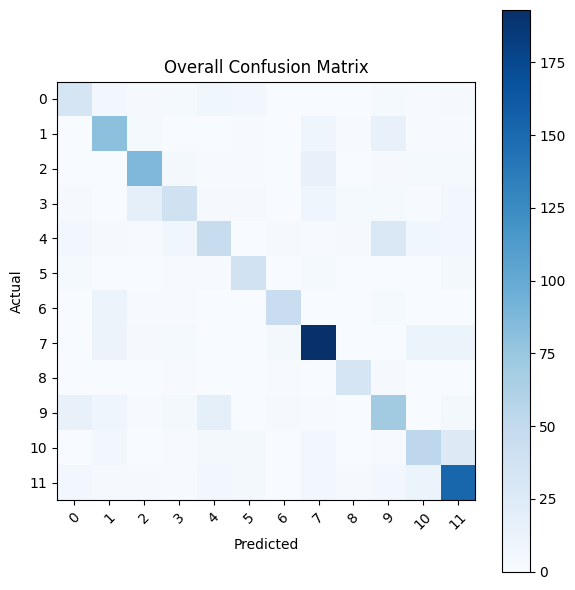

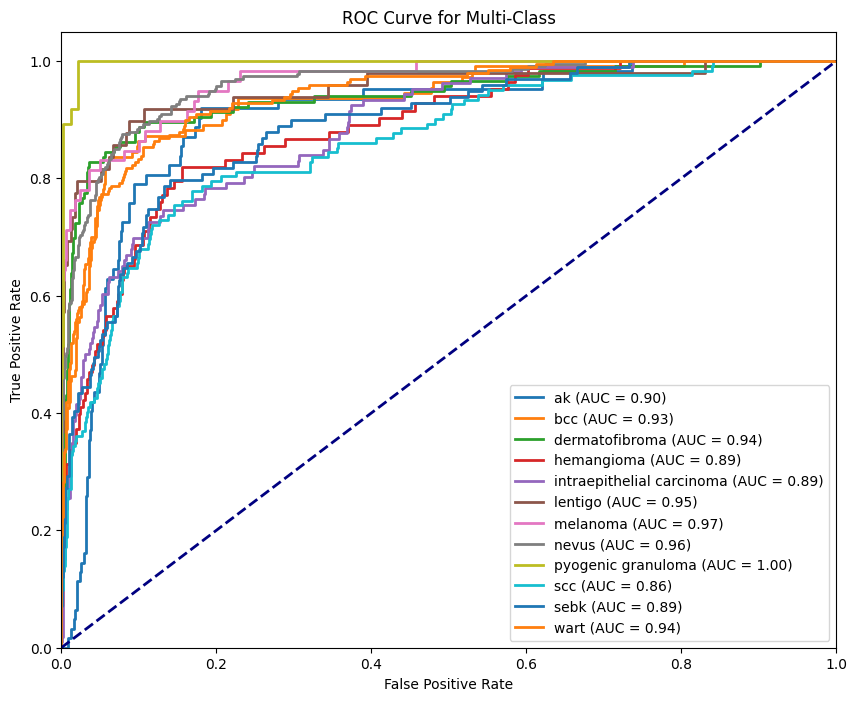

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import label_binarize
import tqdm

@torch.no_grad()
def test_all_classes(model, dataloader):
    model.eval()
    class_correct = [0] * num_classes  # 用于记录每个类别的正确预测数
    class_total = [0] * num_classes  # 用于记录每个类别的总样本数

    all_true_labels = []
    all_pred_labels = []
    all_scores = []  # 存储模型的输出分数矩阵

    confusion_matrices = []  # 存储每个类别的混淆矩阵

    for images, labels in tqdm.tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels = labels.cpu().numpy()
        pred_labels = predicted.cpu().numpy()

        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)


        scores = outputs.cpu().numpy()
        all_scores.extend(scores)


        for i in range(len(labels)):
            label = true_labels[i]
            pred = pred_labels[i]
            class_correct[label] += (pred == label)
            class_total[label] += 1

        # 计算混淆矩阵并添加到列表中
        cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))
        confusion_matrices.append(cm)

    # 生成整体混淆矩阵
    overall_confusion_matrix = np.sum(confusion_matrices, axis=0)

    # 保存整体混淆矩阵为PDF
    pdf_pages_confusion = PdfPages("overall_confusion_matrix.pdf")
    plt.figure(figsize=(6, 6))
    plt.imshow(overall_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Overall Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, np.arange(num_classes), rotation=45)
    plt.yticks(tick_marks, np.arange(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    pdf_pages_confusion.savefig()
    pdf_pages_confusion.close()

    for i in range(num_classes):
        class_name = int_to_classes_asan[i]
        accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0

        # 计算F1分数
        f1 = f1_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        # 计算召回率
        recall = recall_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        print(f"Class {class_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

    y_true_binary = label_binarize(all_true_labels, classes=np.arange(num_classes))

     # 获取类别名称
    class_names = [int_to_classes_asan[i] for i in range(num_classes)]

    return y_true_binary, np.array(all_scores), class_names



# 调用函数测试所有类别
# 调用函数获取真实标签和模型分数
# 调用函数获取真实标签和模型分数
y_true_binary, scores, class_names = test_all_classes(Globals.model1, ISICEmbTestLoader)

# 调用绘制ROC曲线函数 # 请确保设置正确的类别数量
# 调用函数绘制多类别ROC曲线并保存为PDF
pdf_filename = "multiclass_roc_curve.pdf"
plot_multiclass_roc(y_true_binary, scores, num_classes, class_names, pdf_filename)

100%|██████████| 40/40 [00:01<00:00, 30.68it/s]


Class ak - Accuracy: 0.4355, F1 Score: 0.4154, Recall: 0.4355
Class bcc - Accuracy: 0.7273, F1 Score: 0.6667, Recall: 0.7273
Class dermatofibroma - Accuracy: 0.7759, F1 Score: 0.7860, Recall: 0.7759
Class hemangioma - Accuracy: 0.5181, F1 Score: 0.5695, Recall: 0.5181
Class intraepithelial carcinoma - Accuracy: 0.4151, F1 Score: 0.4889, Recall: 0.4151
Class lentigo - Accuracy: 0.7551, F1 Score: 0.6549, Recall: 0.7551
Class melanoma - Accuracy: 0.7797, F1 Score: 0.7797, Recall: 0.7797
Class nevus - Accuracy: 0.7039, F1 Score: 0.7828, Recall: 0.7039
Class pyogenic granuloma - Accuracy: 0.8919, F1 Score: 0.8684, Recall: 0.8919
Class scc - Accuracy: 0.6311, F1 Score: 0.5662, Recall: 0.6311
Class sebk - Accuracy: 0.5455, F1 Score: 0.5596, Recall: 0.5455
Class wart - Accuracy: 0.8081, F1 Score: 0.7494, Recall: 0.8081


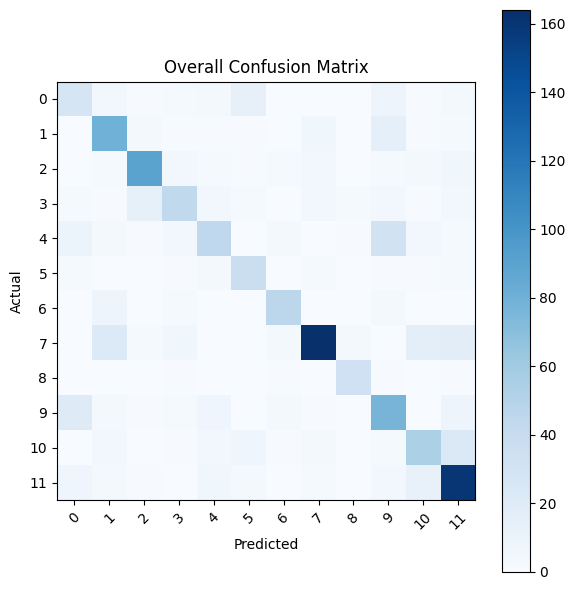

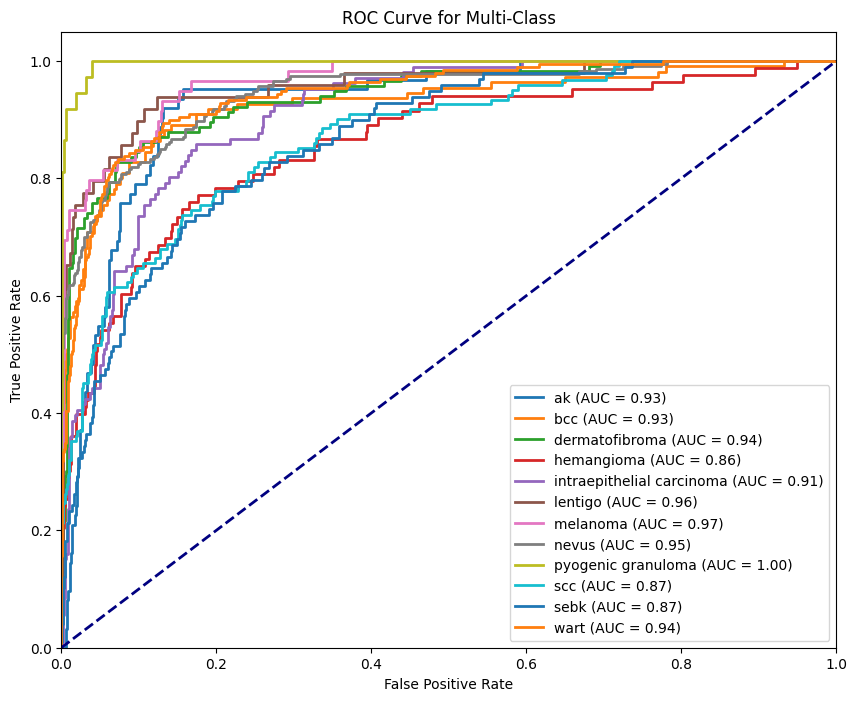

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import label_binarize
import tqdm

@torch.no_grad()
def test_all_classes(model, dataloader):
    model.eval()
    class_correct = [0] * num_classes  # 用于记录每个类别的正确预测数
    class_total = [0] * num_classes  # 用于记录每个类别的总样本数

    all_true_labels = []
    all_pred_labels = []
    all_scores = []  # 存储模型的输出分数矩阵

    confusion_matrices = []  # 存储每个类别的混淆矩阵

    for images, labels in tqdm.tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels = labels.cpu().numpy()
        pred_labels = predicted.cpu().numpy()

        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)


        scores = outputs.cpu().numpy()
        all_scores.extend(scores)


        for i in range(len(labels)):
            label = true_labels[i]
            pred = pred_labels[i]
            class_correct[label] += (pred == label)
            class_total[label] += 1

        # 计算混淆矩阵并添加到列表中
        cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))
        confusion_matrices.append(cm)

    # 生成整体混淆矩阵
    overall_confusion_matrix = np.sum(confusion_matrices, axis=0)

    # 保存整体混淆矩阵为PDF
    pdf_pages_confusion = PdfPages("overall_confusion_matrix.pdf")
    plt.figure(figsize=(6, 6))
    plt.imshow(overall_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Overall Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, np.arange(num_classes), rotation=45)
    plt.yticks(tick_marks, np.arange(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    pdf_pages_confusion.savefig()
    pdf_pages_confusion.close()

    for i in range(num_classes):
        class_name = int_to_classes_asan[i]
        accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0

        # 计算F1分数
        f1 = f1_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        # 计算召回率
        recall = recall_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        print(f"Class {class_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

    y_true_binary = label_binarize(all_true_labels, classes=np.arange(num_classes))

     # 获取类别名称
    class_names = [int_to_classes_asan[i] for i in range(num_classes)]

    return y_true_binary, np.array(all_scores), class_names



# 调用函数测试所有类别
# 调用函数获取真实标签和模型分数
# 调用函数获取真实标签和模型分数
y_true_binary, scores, class_names = test_all_classes(Globals.model2, ISICEmbTestLoader)

# 调用绘制ROC曲线函数 # 请确保设置正确的类别数量
# 调用函数绘制多类别ROC曲线并保存为PDF
pdf_filename = "multiclass_roc_curve.pdf"
plot_multiclass_roc(y_true_binary, scores, num_classes, class_names, pdf_filename)

100%|██████████| 40/40 [00:01<00:00, 24.13it/s]


Class ak - Accuracy: 0.4194, F1 Score: 0.4561, Recall: 0.4194
Class bcc - Accuracy: 0.7000, F1 Score: 0.6814, Recall: 0.7000
Class dermatofibroma - Accuracy: 0.7845, F1 Score: 0.7811, Recall: 0.7845
Class hemangioma - Accuracy: 0.4458, F1 Score: 0.5248, Recall: 0.4458
Class intraepithelial carcinoma - Accuracy: 0.5189, F1 Score: 0.5612, Recall: 0.5189
Class lentigo - Accuracy: 0.7959, F1 Score: 0.6446, Recall: 0.7959
Class melanoma - Accuracy: 0.7797, F1 Score: 0.8000, Recall: 0.7797
Class nevus - Accuracy: 0.8326, F1 Score: 0.8117, Recall: 0.8326
Class pyogenic granuloma - Accuracy: 0.8378, F1 Score: 0.8857, Recall: 0.8378
Class scc - Accuracy: 0.6148, F1 Score: 0.5639, Recall: 0.6148
Class sebk - Accuracy: 0.5556, F1 Score: 0.5759, Recall: 0.5556
Class wart - Accuracy: 0.7576, F1 Score: 0.7557, Recall: 0.7576


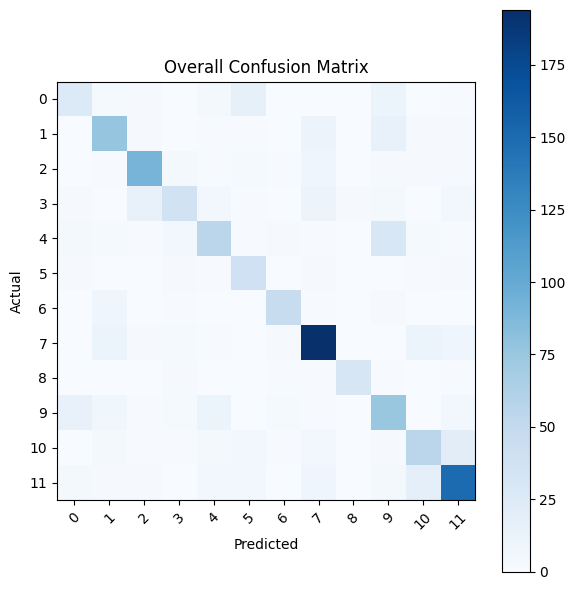

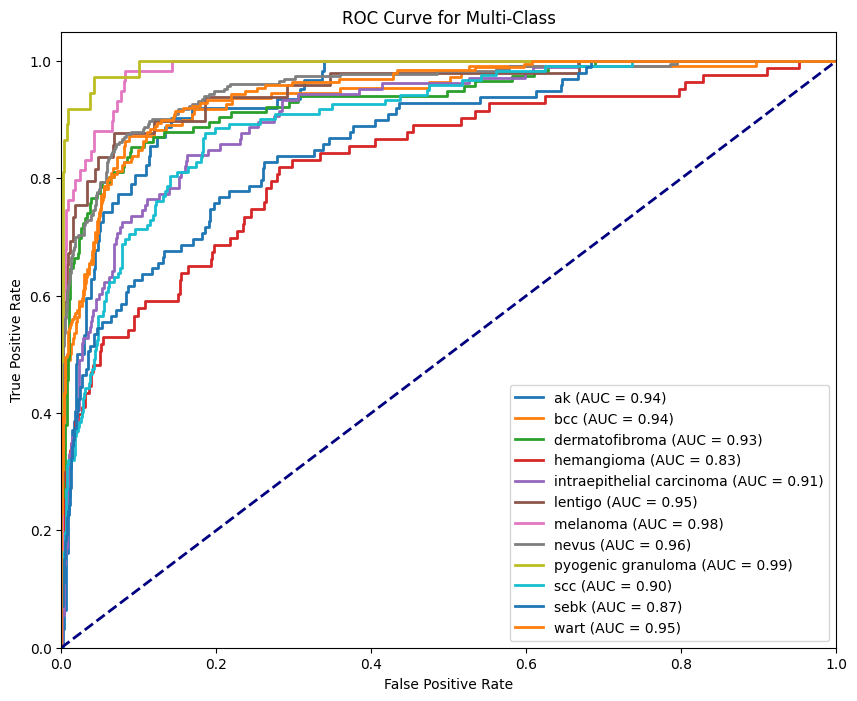

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import label_binarize
import tqdm

@torch.no_grad()
def test_all_classes(model, dataloader):
    model.eval()
    class_correct = [0] * num_classes  # 用于记录每个类别的正确预测数
    class_total = [0] * num_classes  # 用于记录每个类别的总样本数

    all_true_labels = []
    all_pred_labels = []
    all_scores = []  # 存储模型的输出分数矩阵

    confusion_matrices = []  # 存储每个类别的混淆矩阵

    for images, labels in tqdm.tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels = labels.cpu().numpy()
        pred_labels = predicted.cpu().numpy()

        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)


        scores = outputs.cpu().numpy()
        all_scores.extend(scores)


        for i in range(len(labels)):
            label = true_labels[i]
            pred = pred_labels[i]
            class_correct[label] += (pred == label)
            class_total[label] += 1

        # 计算混淆矩阵并添加到列表中
        cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))
        confusion_matrices.append(cm)

    # 生成整体混淆矩阵
    overall_confusion_matrix = np.sum(confusion_matrices, axis=0)

    # 保存整体混淆矩阵为PDF
    pdf_pages_confusion = PdfPages("overall_confusion_matrix.pdf")
    plt.figure(figsize=(6, 6))
    plt.imshow(overall_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Overall Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, np.arange(num_classes), rotation=45)
    plt.yticks(tick_marks, np.arange(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    pdf_pages_confusion.savefig()
    pdf_pages_confusion.close()

    for i in range(num_classes):
        class_name = int_to_classes_asan[i]
        accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0

        # 计算F1分数
        f1 = f1_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        # 计算召回率
        recall = recall_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        print(f"Class {class_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

    y_true_binary = label_binarize(all_true_labels, classes=np.arange(num_classes))

     # 获取类别名称
    class_names = [int_to_classes_asan[i] for i in range(num_classes)]

    return y_true_binary, np.array(all_scores), class_names



# 调用函数测试所有类别
# 调用函数获取真实标签和模型分数
# 调用函数获取真实标签和模型分数
y_true_binary, scores, class_names = test_all_classes(Globals.model2, ISICEmbTestLoader)

# 调用绘制ROC曲线函数 # 请确保设置正确的类别数量
# 调用函数绘制多类别ROC曲线并保存为PDF
pdf_filename = "multiclass_roc_curve.pdf"
plot_multiclass_roc(y_true_binary, scores, num_classes, class_names, pdf_filename)

Class ak - Accuracy: 0.4355, F1 Score: 0.4154, Recall: 0.4355
Class bcc - Accuracy: 0.7273, F1 Score: 0.6667, Recall: 0.7273
Class dermatofibroma - Accuracy: 0.7759, F1 Score: 0.7860, Recall: 0.7759
Class hemangioma - Accuracy: 0.5181, F1 Score: 0.5695, Recall: 0.5181
Class intraepithelial carcinoma - Accuracy: 0.4151, F1 Score: 0.4889, Recall: 0.4151
Class lentigo - Accuracy: 0.7551, F1 Score: 0.6549, Recall: 0.7551
Class melanoma - Accuracy: 0.7797, F1 Score: 0.7797, Recall: 0.7797
Class nevus - Accuracy: 0.7039, F1 Score: 0.7828, Recall: 0.7039
Class pyogenic granuloma - Accuracy: 0.8919, F1 Score: 0.8684, Recall: 0.8919
Class scc - Accuracy: 0.6311, F1 Score: 0.5662, Recall: 0.6311
Class sebk - Accuracy: 0.5455, F1 Score: 0.5596, Recall: 0.5455
Class wart - Accuracy: 0.8081, F1 Score: 0.7494, Recall: 0.8081

100%|██████████| 40/40 [00:02<00:00, 16.33it/s]


Class ak - Accuracy: 0.6129, F1 Score: 0.5278, Recall: 0.6129
Class bcc - Accuracy: 0.6909, F1 Score: 0.6756, Recall: 0.6909
Class dermatofibroma - Accuracy: 0.7586, F1 Score: 0.7652, Recall: 0.7586
Class hemangioma - Accuracy: 0.5663, F1 Score: 0.5311, Recall: 0.5663
Class intraepithelial carcinoma - Accuracy: 0.4151, F1 Score: 0.5057, Recall: 0.4151
Class lentigo - Accuracy: 0.7143, F1 Score: 0.7778, Recall: 0.7143
Class melanoma - Accuracy: 0.7458, F1 Score: 0.7857, Recall: 0.7458
Class nevus - Accuracy: 0.8326, F1 Score: 0.8308, Recall: 0.8326
Class pyogenic granuloma - Accuracy: 0.5676, F1 Score: 0.6885, Recall: 0.5676
Class scc - Accuracy: 0.5492, F1 Score: 0.5360, Recall: 0.5492
Class sebk - Accuracy: 0.6061, F1 Score: 0.5742, Recall: 0.6061
Class wart - Accuracy: 0.7828, F1 Score: 0.7579, Recall: 0.7828


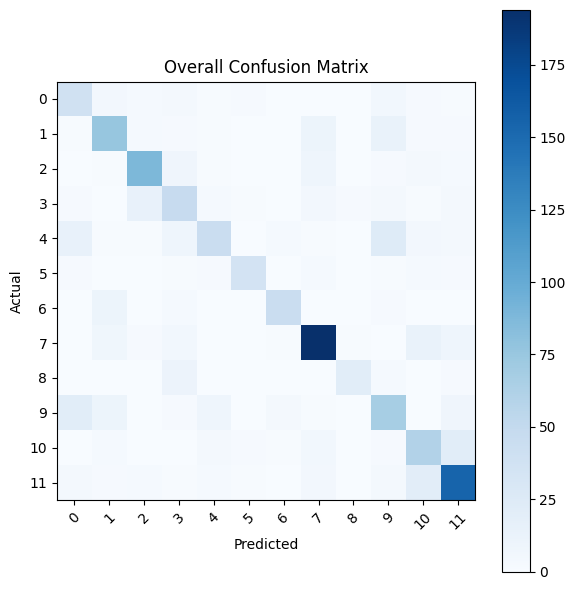

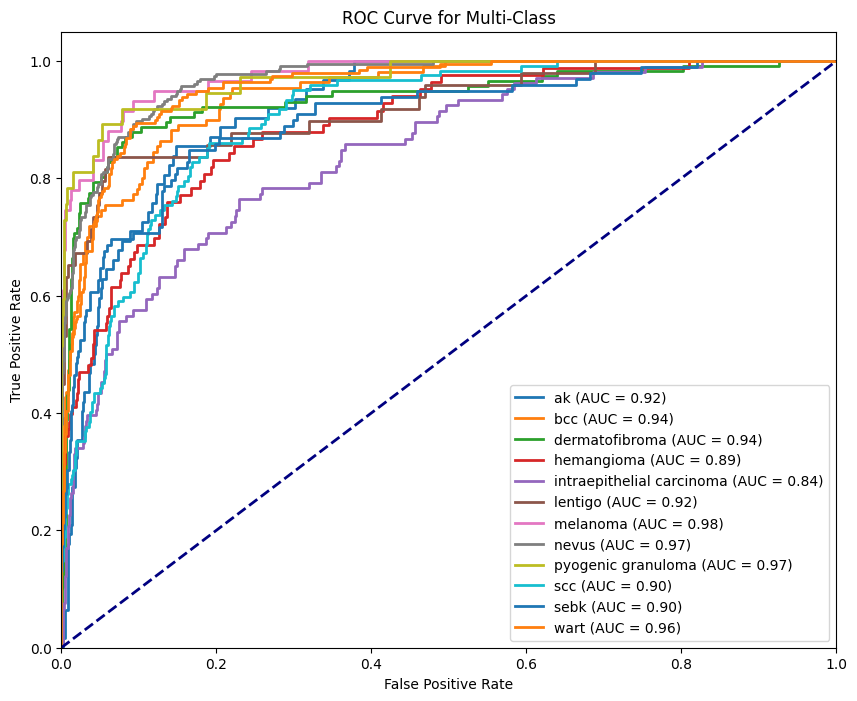

In [ ]:
#@title unsampled
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import label_binarize
import tqdm

@torch.no_grad()
def test_all_classes(model, dataloader):
    model.eval()
    class_correct = [0] * num_classes  # 用于记录每个类别的正确预测数
    class_total = [0] * num_classes  # 用于记录每个类别的总样本数

    all_true_labels = []
    all_pred_labels = []
    all_scores = []  # 存储模型的输出分数矩阵

    confusion_matrices = []  # 存储每个类别的混淆矩阵

    for images, labels in tqdm.tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels = labels.cpu().numpy()
        pred_labels = predicted.cpu().numpy()

        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)


        scores = outputs.cpu().numpy()
        all_scores.extend(scores)


        for i in range(len(labels)):
            label = true_labels[i]
            pred = pred_labels[i]
            class_correct[label] += (pred == label)
            class_total[label] += 1

        # 计算混淆矩阵并添加到列表中
        cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))
        confusion_matrices.append(cm)

    # 生成整体混淆矩阵
    overall_confusion_matrix = np.sum(confusion_matrices, axis=0)

    # 保存整体混淆矩阵为PDF
    pdf_pages_confusion = PdfPages("overall_confusion_matrix.pdf")
    plt.figure(figsize=(6, 6))
    plt.imshow(overall_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Overall Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, np.arange(num_classes), rotation=45)
    plt.yticks(tick_marks, np.arange(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    pdf_pages_confusion.savefig()
    pdf_pages_confusion.close()

    for i in range(num_classes):
        class_name = int_to_classes_asan[i]
        accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0

        # 计算F1分数
        f1 = f1_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        # 计算召回率
        recall = recall_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        print(f"Class {class_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

    y_true_binary = label_binarize(all_true_labels, classes=np.arange(num_classes))

     # 获取类别名称
    class_names = [int_to_classes_asan[i] for i in range(num_classes)]

    return y_true_binary, np.array(all_scores), class_names



# 调用函数测试所有类别
# 调用函数获取真实标签和模型分数
# 调用函数获取真实标签和模型分数
y_true_binary, scores, class_names = test_all_classes(Globals.model2, ISICEmbTestLoader)

# 调用绘制ROC曲线函数 # 请确保设置正确的类别数量
# 调用函数绘制多类别ROC曲线并保存为PDF
pdf_filename = "multiclass_roc_curve.pdf"
plot_multiclass_roc(y_true_binary, scores, num_classes, class_names, pdf_filename)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from matplotlib.backends.backend_pdf import PdfPages

def plot_multiclass_roc(y_true, y_score, num_classes, class_names, pdf_filename):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class')
    plt.legend(loc="lower right")

    # 保存为PDF
    pdf_pages = PdfPages(pdf_filename)
    pdf_pages.savefig()
    pdf_pages.close()

1274
1274
Class ak - Accuracy: 0.4677, F1 Score: 0.4296, Recall: 0.4677
Class bcc - Accuracy: 0.6091, F1 Score: 0.6091, Recall: 0.6091
Class dermatofibroma - Accuracy: 0.7931, F1 Score: 0.7331, Recall: 0.7931
Class hemangioma - Accuracy: 0.4578, F1 Score: 0.5278, Recall: 0.4578
Class intraepithelial carcinoma - Accuracy: 0.3962, F1 Score: 0.4421, Recall: 0.3962
Class lentigo - Accuracy: 0.7755, F1 Score: 0.6667, Recall: 0.7755
Class melanoma - Accuracy: 0.7288, F1 Score: 0.7167, Recall: 0.7288
Class nevus - Accuracy: 0.7039, F1 Score: 0.7421, Recall: 0.7039
Class pyogenic granuloma - Accuracy: 0.8919, F1 Score: 0.6535, Recall: 0.8919
Class scc - Accuracy: 0.4918, F1 Score: 0.4959, Recall: 0.4918
Class sebk - Accuracy: 0.6162, F1 Score: 0.5728, Recall: 0.6162
Class wart - Accuracy: 0.6667, F1 Score: 0.7021, Recall: 0.6667


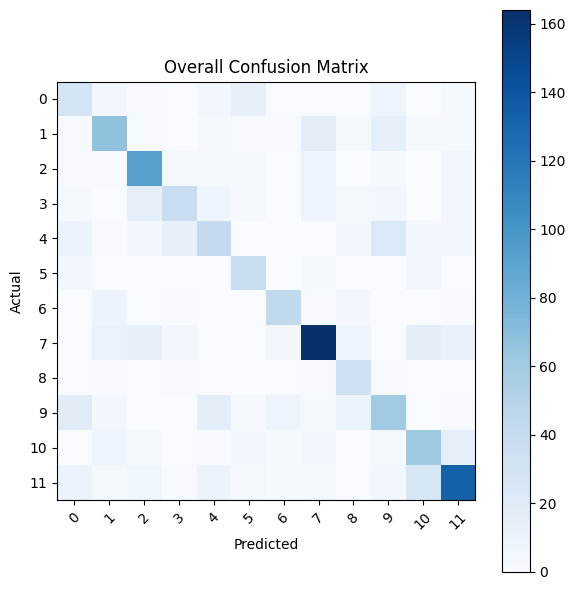

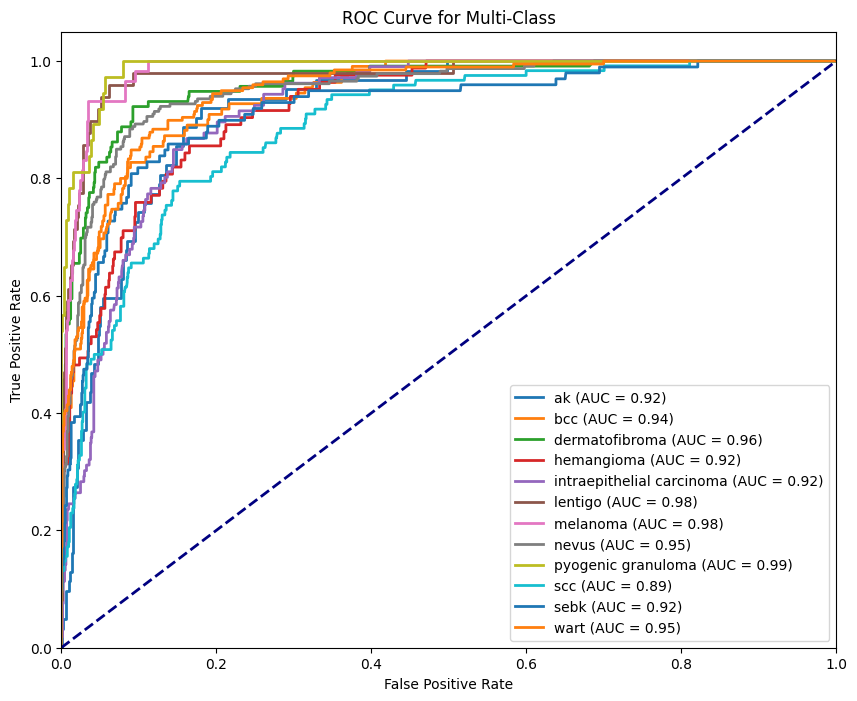

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import label_binarize
import tqdm

@torch.no_grad()
def test_all_classes(model, test_data, test_labels):

    class_correct = [0] * num_classes  # 用于记录每个类别的正确预测数
    class_total = [0] * num_classes  # 用于记录每个类别的总样本数

    all_true_labels = []
    all_pred_labels = []
    all_scores = []  # 存储模型的输出分数矩阵

    confusion_matrices = []  # 存储每个类别的混淆矩阵

    outputs = model.predict(test_data)
    scores = model.predict_proba(test_data)
    #_, predicted = torch.max(outputs, 1)

    true_labels = test_labels
    pred_labels = outputs

    all_true_labels.extend(true_labels)
    all_pred_labels.extend(pred_labels)


    #scores = outputs.cpu().numpy()
    #all_scores.extend(scores)


    for i in range(len(true_labels)):
        label = int(true_labels[i])
        pred = int(pred_labels[i])
        class_correct[label] += (pred == label)
        class_total[label] += 1
    print(len(true_labels))
    print(len(pred_labels))
        # 计算混淆矩阵并添加到列表中
    cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))
    confusion_matrices.append(cm)

    # 生成整体混淆矩阵
    overall_confusion_matrix = np.sum(confusion_matrices, axis=0)

    # 保存整体混淆矩阵为PDF
    pdf_pages_confusion = PdfPages("overall_confusion_matrix.pdf")
    plt.figure(figsize=(6, 6))
    plt.imshow(overall_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Overall Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, np.arange(num_classes), rotation=45)
    plt.yticks(tick_marks, np.arange(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    pdf_pages_confusion.savefig()
    pdf_pages_confusion.close()

    for i in range(num_classes):
        class_name = int_to_classes_asan[i]
        accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0

        # 计算F1分数
        f1 = f1_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        # 计算召回率
        recall = recall_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        print(f"Class {class_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

    y_true_binary = label_binarize(all_true_labels, classes=np.arange(num_classes))

     # 获取类别名称
    class_names = [int_to_classes_asan[i] for i in range(num_classes)]

    return y_true_binary, np.array(scores), class_names



# 调用函数测试所有类别
# 调用函数获取真实标签和模型分数
# 调用函数获取真实标签和模型分数
y_true_binary, scores, class_names = test_all_classes(brf, asan_test_embs, asan_test_labels)

# 调用绘制ROC曲线函数
num_classes = 12 # 请确保设置正确的类别数量
# 调用函数绘制多类别ROC曲线并保存为PDF
pdf_filename = "multiclass_roc_curve.pdf"
plot_multiclass_roc(y_true_binary, scores, num_classes, class_names, pdf_filename)